In [ ]:
%reload_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import ast

from preprocessing import obtain_chembl_data,combine_chembl_papyrus_mutants,merge_chembl_papyrus_mutants
from annotation import *

#### Curate round 1 annotation (semi-manual curation)

In [2]:
# Read round 1 annotated assays making sure that columns containing lists are read as lists
def convert_to_list(s):
    return ast.literal_eval(s)
converters = {'aa_change': convert_to_list,
              'mutants': convert_to_list}

round1_assays = pd.read_csv('..\..\data\chembl31_annotated_assays_round1.csv', sep='\t', converters=converters)
round1_assays

,assay_id,description,accession,sequence,mutation,aa_change,mutants,target_id,Protein_Type
0,83907,In vivo inhibitory activity against human Hepa...,Q9Y251,MLLRSKPALPPPLMLLLLGPLGPLSPGALPRPAQAQDVVDLDFFTQ...,NaN,[],[],Q9Y251_WT,WT
1,154606,Inhibitory activity against Palmitoyl-CoA oxid...,P07872,MNPDLRKERASATFNPELITHILDGSPENTRRRREIENLILNDPDF...,NaN,[],[],P07872_WT,WT
2,51352,Inhibition of cytochrome P450 1A2 of isolated ...,P05177,MALSQSVPFSATELLLASAIFCLVFWVLKGLRPRVPKGLKSPPEPW...,NaN,[],[],P05177_WT,WT
3,51895,Inhibition of cytochrome P450 3A4 of isolated ...,P08684,MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPF...,NaN,[],[],P08684_WT,WT
4,51528,Inhibition of cytochrome P450 2C9 of isolated ...,P11712,MDSLVVLVLCLSCLLLLSLWRQSSGRGKLPPGPTPLPVIGNILQIG...,NaN,[],[],P11712_WT,WT
...,...,...,...,...,...,...,...,...,...
376228,2136225,KinomeScan assay: inhibition of LATS2,Q9NRM7,MRPKTFPATTYSGNSRQRLQEIREGLKQPSKSSVQGLPAGPNSDTS...,NaN,[],[],Q9NRM7_WT,WT
376229,2136385,KinomeScan assay: inhibition of ROCK1,Q13464,MSTGDSFETRFEKMDNLLRDPKSEVNSDCLLDGLDALVYDLDFPAL...,NaN,[],[],Q13464_WT,WT
376230,2136386,KinomeScan assay: inhibition of ROCK2,O75116,MSRPPPTGKMPGAPETAPGDGAGASRQRKLEALIRDPRSPINVESL...,NaN,[],[],O75116_WT,WT
376231,2136430,KinomeScan assay: inhibition of TGFBR2,P37173,MGRGLLRGLWPLHIVLWTRIASTIPPHVQKSVNNDMIVTDNNGAVK...,NaN,[],[],P37173_WT,WT


In [3]:
# Get additional information for assays to check where differences in local and ChEMBL annotations might come from
def get_assay_info(assay_data:pd.DataFrame, chembl_version: str):
    """
    Get additional assay information
    """
    # Extract from ChEMBL information about assays
    query = """
            SELECT *
            FROM assays
                INNER JOIN target_dictionary
                    ON assays.tid = target_dictionary.tid
                INNER JOIN target_components
                    ON target_dictionary.tid = target_components.tid
                INNER JOIN component_sequences
                    ON target_components.component_id = component_sequences.component_id
            """

    chembl_assay_information = chembl_downloader.query(query, version=chembl_version,
                                                       prefix=['mutants-in-pcm', 'chembl'])

    # Merge assay information to annotated assays
    assay_data_ExtraInfo = pd.merge(assay_data, chembl_assay_information, how='left', on=['assay_id','accession'])

    return assay_data_ExtraInfo

round1_assays_ExtraInfo = get_assay_info(round1_assays, '31')

##### False positives (i.e. annotated by us but not by ChEMBL)

The annotation of false positives was done by manually checking the 651 new annotations and 182 "rescued" UNDEFINED
MUTATION assay-accession pairs. The assays descriptions were checked against the annotated mutations. Assay-accession
 pairs that were considered false positives were extracted in C:\Users\gorostiolam\Documents\Gorostiola Gonzalez,
 Marina\PROJECTS\6_Mutants_PCM\DATA\2_Analysis\0_annotation_analysis\round_1\new_annotations_incorrect.xlsx and given a
"reason" flag that described that reason why the annotated mutation was likely given. This should help categorize the
 false positives and give ideas to improve the annotation pipeline. The different reasons were further grouped into
 more general groups in "group_reason" flag.

In [4]:
# Check newly annotated assays (not previously annotated on ChEMBL)
round1_assays_ExtraInfo[~round1_assays_ExtraInfo['target_id'].str.contains('_WT') &  round1_assays_ExtraInfo['mutation'].isnull() ]

,assay_id,description_x,accession,sequence_x,mutation,aa_change,mutants,target_id,Protein_Type,doc_id,...,homologue,component_id,component_type,sequence_y,sequence_md5sum,description_y,tax_id,organism,db_source,db_version
3103,226874,Ratio of IC50 value against hNK1 receptor to t...,P25103,MDNVLPVDSDLSPNISTNTSEPNQFVQPAWQIVLWAAAYTVIVVTS...,NaN,[Q165A],[Q165A],P25103_Q165A,Q165A,13275,...,0,235,PROTEIN,MDNVLPVDSDLSPNISTNTSEPNQFVQPAWQIVLWAAAYTVIVVTS...,2ef7318627a5eee5d4155c6f70c38a09,Substance-P receptor,9606,Homo sapiens,SWISS-PROT,2022_02
5557,153379,Transcriptional activation activity on human I...,Q07869,MVDTESPLCPLSPLEAGDLESPLSEEFLQEMGNIQEISQSIGEDSS...,NaN,[I272F],[I272F],Q07869_I272F,I272F,5772,...,0,245,PROTEIN,MVDTESPLCPLSPLEAGDLESPLSEEFLQEMGNIQEISQSIGEDSS...,f758f3566fa5c02ea133ec7a89a5d06d,Peroxisome proliferator-activated receptor alpha,9606,Homo sapiens,SWISS-PROT,2022_02
5558,153380,Transcriptional activation activity on human T...,Q07869,MVDTESPLCPLSPLEAGDLESPLSEEFLQEMGNIQEISQSIGEDSS...,NaN,[T279M],[T279M],Q07869_T279M,T279M,5772,...,0,245,PROTEIN,MVDTESPLCPLSPLEAGDLESPLSEEFLQEMGNIQEISQSIGEDSS...,f758f3566fa5c02ea133ec7a89a5d06d,Peroxisome proliferator-activated receptor alpha,9606,Homo sapiens,SWISS-PROT,2022_02
5559,153557,Ratio of transcriptional activation of I272F m...,Q07869,MVDTESPLCPLSPLEAGDLESPLSEEFLQEMGNIQEISQSIGEDSS...,NaN,[I272F],[I272F],Q07869_I272F,I272F,5772,...,0,245,PROTEIN,MVDTESPLCPLSPLEAGDLESPLSEEFLQEMGNIQEISQSIGEDSS...,f758f3566fa5c02ea133ec7a89a5d06d,Peroxisome proliferator-activated receptor alpha,9606,Homo sapiens,SWISS-PROT,2022_02
5560,153560,Ratio of transcriptional activation of T279M m...,Q07869,MVDTESPLCPLSPLEAGDLESPLSEEFLQEMGNIQEISQSIGEDSS...,NaN,[T279M],[T279M],Q07869_T279M,T279M,5772,...,0,245,PROTEIN,MVDTESPLCPLSPLEAGDLESPLSEEFLQEMGNIQEISQSIGEDSS...,f758f3566fa5c02ea133ec7a89a5d06d,Peroxisome proliferator-activated receptor alpha,9606,Homo sapiens,SWISS-PROT,2022_02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371279,2113388,Inhibition of human non-phosphorylated ABL1 F3...,P00519,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,NaN,[F317L],[F317L],P00519_F317L,F317L,120543,...,0,173,PROTEIN,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,d24f1ea01ac4c8d96e75dd9550a0fb09,Tyrosine-protein kinase ABL1,9606,Homo sapiens,SWISS-PROT,2022_02
373864,2122982,Inhibition of MLL1 (unknown origin)-mediated H...,Q03164,MAHSCRWRFPARPGTTGGGGGGGRRGLGGAPRQRVPALLLPPGPPV...,NaN,[H3K],[H3K],Q03164_H3K,H3K,120915,...,0,5131,PROTEIN,MAHSCRWRFPARPGTTGGGGGGGRRGLGGAPRQRVPALLLPPGPPV...,f90e5c53fc570d85e49f666ad445dcde,Histone-lysine N-methyltransferase 2A,9606,Homo sapiens,SWISS-PROT,2022_02
374254,2125019,Activation of human PKM2-C424A expressed in Es...,P14618,MSKPHSEAGTAFIQTQQLHAAMADTFLEHMCRLDIDSPPITARNTG...,NaN,[C424A],[C424A],P14618_C424A,C424A,120974,...,0,4349,PROTEIN,MSKPHSEAGTAFIQTQQLHAAMADTFLEHMCRLDIDSPPITARNTG...,b9f341db7edc1c70c1439f8176ea2889,Pyruvate kinase PKM,9606,Homo sapiens,SWISS-PROT,2022_02
374819,2127601,Binding affinity to human partial length MCL1 ...,Q07820,MFGLKRNAVIGLNLYCGGAGLGAGSGGATRPGGRLLATEKEASARR...,NaN,"[D172N, L2S]",[D172N],Q07820_D172N,D172N,121070,...,0,2678,PROTEIN,MFGLKRNAVIGLNLYCGGAGLGAGSGGATRPGGRLLATEKEASARR...,ac05f6a57fb5fffa7a8ddcdf26e1ba8d,Induced myeloid leukemia cell differentiation ...,9606,Homo sapiens,SWISS-PROT,2022_02


In [5]:
# Check newly annotated assays (annotated as 'UNDEFINED MUTATION' in ChEMBL)
round1_assays_ExtraInfo[~round1_assays_ExtraInfo['target_id'].str.contains('_WT') &
                                  (round1_assays_ExtraInfo['mutation'] == 'UNDEFINED MUTATION')]#.groupby(['curated_by'])['assay_id'].count()

,assay_id,description_x,accession,sequence_x,mutation,aa_change,mutants,target_id,Protein_Type,doc_id,...,homologue,component_id,component_type,sequence_y,sequence_md5sum,description_y,tax_id,organism,db_source,db_version
225304,1433633,Potentiation of human CFTR F508del/G551D mutan...,P13569,MQRSPLEKASVVSKLFFSWTRPILRKGYRQRLELSDIYQIPSVDSA...,UNDEFINED MUTATION,[G551D],[G551D],P13569_G551D,G551D,89790,...,0,2370,PROTEIN,MQRSPLEKASVVSKLFFSWTRPILRKGYRQRLELSDIYQIPSVDSA...,f29b8c0a9056a0f7680f3290d259b6ac,Cystic fibrosis transmembrane conductance regu...,9606,Homo sapiens,SWISS-PROT,2022_02
227327,1442036,Inhibition of KIT V559/T670I mutant (unknown o...,P10721,MRGARGAWDFLCVLLLLLRVQTGSSQPSVSPGEPSPPSIHPGKSDL...,UNDEFINED MUTATION,[T670I],[T670I],P10721_T670I,T670I,89287,...,0,255,PROTEIN,MRGARGAWDFLCVLLLLLRVQTGSSQPSVSPGEPSPPSIHPGKSDL...,f753f2b2d9752a30646c83e8630d1df8,Mast/stem cell growth factor receptor Kit,9606,Homo sapiens,SWISS-PROT,2022_02
228138,1435798,Inhibition of wild type HIV1 reverse transcrip...,Q72547,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...,UNDEFINED MUTATION,"[Y181I, Y181C]","[Y181C, Y181I]",Q72547_Y181C_Y181I,Y181C;Y181I,89737,...,0,375,PROTEIN,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...,347541fa98e55ebf1791ded88f229d8c,Reverse transcriptase/RNaseH,11676,Human immunodeficiency virus 1,TREMBL,2022_02
228447,1440950,Inhibition of EGFR T790M/del746 to 750 mutant ...,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,UNDEFINED MUTATION,[T790M],[T790M],P00533_T790M,T790M,89694,...,0,147,PROTEIN,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,99d03b567dbcdd7fb0dd21fb40d5d283,Epidermal growth factor receptor,9606,Homo sapiens,SWISS-PROT,2022_02
228673,1441757,Corrector activity at human bronchial epitheli...,P13569,MQRSPLEKASVVSKLFFSWTRPILRKGYRQRLELSDIYQIPSVDSA...,UNDEFINED MUTATION,[G551D],[G551D],P13569_G551D,G551D,89697,...,0,2370,PROTEIN,MQRSPLEKASVVSKLFFSWTRPILRKGYRQRLELSDIYQIPSVDSA...,f29b8c0a9056a0f7680f3290d259b6ac,Cystic fibrosis transmembrane conductance regu...,9606,Homo sapiens,SWISS-PROT,2022_02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374735,2127220,Binding affinity to 6His-FLAG-Tev-BRDT (1 to 3...,Q58F21,MSLPSRQTAIIVNPPPPEYINTKKNGRLTNQLQYLQKVVLKDLWKH...,UNDEFINED MUTATION,"[Y309A, Y66A]","[Y66A, Y309A]",Q58F21_Y66A_Y309A,Y66A;Y309A,121054,...,0,5553,PROTEIN,MSLPSRQTAIIVNPPPPEYINTKKNGRLTNQLQYLQKVVLKDLWKH...,2ac9e601c29e15829546463a6894420e,Bromodomain testis-specific protein,9606,Homo sapiens,SWISS-PROT,2022_02
374749,2127280,Inhibition of 6His-FLAG-Tev-BRDT (1 to 397 res...,Q58F21,MSLPSRQTAIIVNPPPPEYINTKKNGRLTNQLQYLQKVVLKDLWKH...,UNDEFINED MUTATION,"[Y309A, Y66A]","[Y66A, Y309A]",Q58F21_Y66A_Y309A,Y66A;Y309A,121056,...,0,5553,PROTEIN,MSLPSRQTAIIVNPPPPEYINTKKNGRLTNQLQYLQKVVLKDLWKH...,2ac9e601c29e15829546463a6894420e,Bromodomain testis-specific protein,9606,Homo sapiens,SWISS-PROT,2022_02
374751,2127282,Inhibition of 6His-Thr-BRD3 (1 to 435 residues...,Q15059,MSTATTVAPAGIPATPGPVNPPPPEVSNPSKPGRKTNQLQYMQNVV...,UNDEFINED MUTATION,"[Y348A, Y73A]","[Y73A, Y348A]",Q15059_Y73A_Y348A,Y73A;Y348A,121056,...,0,5554,PROTEIN,MSTATTVAPAGIPATPGPVNPPPPEVSNPSKPGRKTNQLQYMQNVV...,b946c4c397f75fdd24b1c5acba15efa0,Bromodomain-containing protein 3,9606,Homo sapiens,SWISS-PROT,2022_02
374752,2127283,Inhibition of 6His-Thr-BRD2 (1 to 473 residues...,P25440,MLQNVTPHNKLPGEGNAGLLGLGPEAAAPGKRIRKPSLLYEGFESP...,UNDEFINED MUTATION,"[Y386A, Y113A]","[Y113A, Y386A]",P25440_Y113A_Y386A,Y113A;Y386A,121056,...,0,5013,PROTEIN,MLQNVTPHNKLPGEGNAGLLGLGPEAAAPGKRIRKPSLLYEGFESP...,5dd925de15997e9e3938ab23517cdcfc,Bromodomain-containing protein 2,9606,Homo sapiens,SWISS-PROT,2022_02


##### False negatives (i.e. annotated by ChEMBL but not by us)

The annotation of false negatives was done by classifying all rejected ChEMBL mutations into different groups (i.e.
"rejection_flag") defined from an initial visual inspection and talks to the variant annotation team in ChEMBL.
Further relevance/confidence of the different categories were given by further visual inspection.

In [6]:
# Check how many mutations previously annotated in ChEMBL fail validation based on sequence (or exceptions)
# First get the assays that were originally annotated on ChEMBL with a defined mutation
round1_assays_original = round1_assays_ExtraInfo[round1_assays_ExtraInfo['mutation'] !=
                                                                     'UNDEFINED MUTATION'].dropna(subset=['mutation'])

def check_original_valid(row):
    original_mutations = row['mutation'].split(',')
    valid_mutations = list(row['mutants'])
    if all(item in valid_mutations for item in original_mutations):
        return True
    else:
        return False

round1_assays_original_rejected = round1_assays_original[~round1_assays_original.apply(check_original_valid,axis=1)]
round1_assays_original_rejected

,assay_id,description_x,accession,sequence_x,mutation,aa_change,mutants,target_id,Protein_Type,doc_id,...,homologue,component_id,component_type,sequence_y,sequence_md5sum,description_y,tax_id,organism,db_source,db_version
88483,317562,Binding affinity for mutant T877A Androgen rec...,P10275,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...,T878A,[T877A],[],P10275_WT,WT,20674,...,0,187,PROTEIN,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...,0e8126a2b4e057dff4e5e448802e64bf,Androgen receptor,9606,Homo sapiens,SWISS-PROT,2022_02
94476,322454,Inhibitory concentration against IL-3 independ...,P10721,MRGARGAWDFLCVLLLLLRVQTGSSQPSVSPGEPSPPSIHPGKSDL...,D816V,[D816V],[],P10721_WT,WT,30197,...,0,255,PROTEIN,MRGARGAWDFLCVLLLLLRVQTGSSQPSVSPGEPSPPSIHPGKSDL...,f753f2b2d9752a30646c83e8630d1df8,Mast/stem cell growth factor receptor Kit,9606,Homo sapiens,SWISS-PROT,2022_02
105052,426971,Ratio of Ki to Km for HCV NS5B RNA polymerase ...,Q8JXU8,RTEEAIYQCCDLDPQARVAIRSLTERLYVGGPLTNSRGENCGYRRX...,S282T,"[S5B, S282T]",[],Q8JXU8_WT,WT,35099,...,0,3671,PROTEIN,RTEEAIYQCCDLDPQARVAIRSLTERLYVGGPLTNSRGENCGYRRX...,3f5012b8af293164261075aeb623fec5,RNA-directed RNA polymerase,11103,Hepatitis C virus,TREMBL,2022_02
105060,426978,Activity of HCV NS5B RNA polymerase S282T asse...,Q8JXU8,RTEEAIYQCCDLDPQARVAIRSLTERLYVGGPLTNSRGENCGYRRX...,S282T,"[S5B, S282T]",[],Q8JXU8_WT,WT,35099,...,0,3671,PROTEIN,RTEEAIYQCCDLDPQARVAIRSLTERLYVGGPLTNSRGENCGYRRX...,3f5012b8af293164261075aeb623fec5,RNA-directed RNA polymerase,11103,Hepatitis C virus,TREMBL,2022_02
107598,445385,Agonist activity at GluR1 I687A mutant express...,P42261,MQHIFAFFCTGFLGAVVGANFPNNIQIGGLFPNQQSQEHAAFRFAL...,I705A,[I687A],[],P42261_WT,WT,36637,...,0,4996,PROTEIN,MQHIFAFFCTGFLGAVVGANFPNNIQIGGLFPNQQSQEHAAFRFAL...,1875787bc6f3513d65588f76d95dede6,Glutamate receptor 1,9606,Homo sapiens,SWISS-PROT,2022_02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374141,2124228,Stabilization of TTR V3OM mutant (unknown orig...,P02766,MASHRLLLLCLAGLVFVSEAGPTGTGESKCPLMVKVLDAVRGSPAI...,V50M,[V3O],[],P02766_WT,WT,120955,...,0,1517,PROTEIN,MASHRLLLLCLAGLVFVSEAGPTGTGESKCPLMVKVLDAVRGSPAI...,6b2e8f183e8bc0d7efc3e9933236616e,Transthyretin,9606,Homo sapiens,SWISS-PROT,2022_02
374142,2124230,Stabilization of TTR V3OM mutant (unknown orig...,P02766,MASHRLLLLCLAGLVFVSEAGPTGTGESKCPLMVKVLDAVRGSPAI...,V50M,[V3O],[],P02766_WT,WT,120955,...,0,1517,PROTEIN,MASHRLLLLCLAGLVFVSEAGPTGTGESKCPLMVKVLDAVRGSPAI...,6b2e8f183e8bc0d7efc3e9933236616e,Transthyretin,9606,Homo sapiens,SWISS-PROT,2022_02
374144,2124234,Binding affinity to TTR V30M mutant (unknown o...,P02766,MASHRLLLLCLAGLVFVSEAGPTGTGESKCPLMVKVLDAVRGSPAI...,V50M,[V30M],[],P02766_WT,WT,120955,...,0,1517,PROTEIN,MASHRLLLLCLAGLVFVSEAGPTGTGESKCPLMVKVLDAVRGSPAI...,6b2e8f183e8bc0d7efc3e9933236616e,Transthyretin,9606,Homo sapiens,SWISS-PROT,2022_02
376126,2135003,Protac activity at CRBN/AR T878A mutant in hum...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,T878A,[T878A],[],Q96SW2_WT,WT,121349,...,0,16927,PROTEIN,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,6322efb1bd9f9859167c6800b30ed7ea,Protein cereblon,9606,Homo sapiens,SWISS-PROT,2022_02


In [7]:
# Classify rejected annotated variants into categories
def give_rejection_flag(row):
    original_mutations = row['mutation'].split(',')
    extracted_mutations = list(row['aa_change'])
    valid_mutations = list(row['mutants'])
    # Category 1: no amino acid change was extracted from the description with the regular expression
    if len(extracted_mutations) == 0:
        # Category 1A: original mutation is a deletion
        if any(['del' in om for om in original_mutations]):
            return 'original_deletion'
        # Category 1B: original mutation is undefined (THIS SHOULD BE ZERO BECAUSE WE FILTER THEM OUT)
        elif any(['UNDEFINED MUTATION' in om for om in original_mutations]):
            return 'original_undefined'
        # Category 1C: other reasons (e.g. tricky definition in description)
        else:
            return 'no_extraction'
    # Category 2: amino acid was extracted but it is not valid
    elif len(extracted_mutations) > 0:
        # Category 2A: original mutation contains a deletion
        if any(['del' in om for om in original_mutations]):
            return 'original_deletion'
        # Category 2A: original and extracted mutations match in all but sequence position (e.g. possible sequence
# renumbering of which ChEMBL was aware of)
        elif (all(f'{om[0]}{om[-1]}' in [f'{em[0]}{em[-1]}' for em in extracted_mutations] for om in
        original_mutations)) and not (all(om[1:-1] in [em[1:-1] for em in extracted_mutations] for om in
        original_mutations)) and (len(valid_mutations) < len(original_mutations)):
            return 'original_shift_exception'
        # Category 2B: original and extracted mutations match, but they are not valid (e.g. wrong accession)
        elif (any(om in extracted_mutations for om in original_mutations)) and (len(valid_mutations) < len
            (original_mutations)):
            if row['target_type'] == 'PROTEIN FAMILY':
                return 'protein_family'
            else:
                return 'original_not_valid'
        # Category 2C: original and extracted mutations do not match at all (e.g. tricky definition in description
# that was known in ChEMBL as an exception)
        elif all(om not in extracted_mutations for om in original_mutations):
            return f'original_exception_{row["curated_by"]}'
    else:
        return 'other'

round1_assays_original_rejected['rejection_flag'] = round1_assays_original_rejected.apply\
    (give_rejection_flag,axis=1)
# Write out file with false negatives
round1_assays_original_rejected.to_csv('../../data/chembl31_rejected_assays_round1.csv', sep='\t',
                                                 index=False)

In [8]:
# Check assays in specific rejection flags
round1_assays_original_rejected[round1_assays_original_rejected['rejection_flag'] == 'original_not_valid']

,assay_id,description_x,accession,sequence_x,mutation,aa_change,mutants,target_id,Protein_Type,doc_id,...,component_id,component_type,sequence_y,sequence_md5sum,description_y,tax_id,organism,db_source,db_version,rejection_flag
94476,322454,Inhibitory concentration against IL-3 independ...,P10721,MRGARGAWDFLCVLLLLLRVQTGSSQPSVSPGEPSPPSIHPGKSDL...,D816V,[D816V],[],P10721_WT,WT,30197,...,255,PROTEIN,MRGARGAWDFLCVLLLLLRVQTGSSQPSVSPGEPSPPSIHPGKSDL...,f753f2b2d9752a30646c83e8630d1df8,Mast/stem cell growth factor receptor Kit,9606,Homo sapiens,SWISS-PROT,2022_02,original_not_valid
105052,426971,Ratio of Ki to Km for HCV NS5B RNA polymerase ...,Q8JXU8,RTEEAIYQCCDLDPQARVAIRSLTERLYVGGPLTNSRGENCGYRRX...,S282T,"[S5B, S282T]",[],Q8JXU8_WT,WT,35099,...,3671,PROTEIN,RTEEAIYQCCDLDPQARVAIRSLTERLYVGGPLTNSRGENCGYRRX...,3f5012b8af293164261075aeb623fec5,RNA-directed RNA polymerase,11103,Hepatitis C virus,TREMBL,2022_02,original_not_valid
105060,426978,Activity of HCV NS5B RNA polymerase S282T asse...,Q8JXU8,RTEEAIYQCCDLDPQARVAIRSLTERLYVGGPLTNSRGENCGYRRX...,S282T,"[S5B, S282T]",[],Q8JXU8_WT,WT,35099,...,3671,PROTEIN,RTEEAIYQCCDLDPQARVAIRSLTERLYVGGPLTNSRGENCGYRRX...,3f5012b8af293164261075aeb623fec5,RNA-directed RNA polymerase,11103,Hepatitis C virus,TREMBL,2022_02,original_not_valid
114623,473343,Binding affinity to NR2B receptor S645A/i641A ...,Q13224,MKPRAECCSPKFWLVLAVLAVSGSRARSQKSPPSIGIAVILVGTSD...,"S645A,I641A","[R2B, S645A]",[S645A],Q13224_S645A,S645A,39129,...,59,PROTEIN,MKPRAECCSPKFWLVLAVLAVSGSRARSQKSPPSIGIAVILVGTSD...,5bd7a79d95518f600df9ac85dd9d542c,"Glutamate receptor ionotropic, NMDA 2B",9606,Homo sapiens,SWISS-PROT,2022_02,original_not_valid
117235,534387,Inhibition of cross-linking of human Pgp TM3T1...,P08183,MDLEGDRNGGAKKKNFFKLNNKSEKDKKEKKPTVSVFSMFRYSNWL...,"T199R,L339C,F728C","[M3T, L339C, F728C]","[L339C, F728C]",P08183_L339C_F728C,L339C;F728C,42551,...,2619,PROTEIN,MDLEGDRNGGAKKKNFFKLNNKSEKDKKEKKPTVSVFSMFRYSNWL...,e8c72a9371a2775313fe0714108c5e40,ATP-dependent translocase ABCB1,9606,Homo sapiens,SWISS-PROT,2022_02,original_not_valid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370917,2111448,Inhibition of p110alpha E542K mutant/p85alpha ...,P27986,MSAEGYQYRALYDYKKEREEDIDLHLGDILTVNKGSLVALGFSDGQ...,E542K,[E542K],[],P27986_WT,WT,120456,...,846,PROTEIN,MSAEGYQYRALYDYKKEREEDIDLHLGDILTVNKGSLVALGFSDGQ...,5fcafd869a5a794742e5d699000e29f8,Phosphatidylinositol 3-kinase regulatory subun...,9606,Homo sapiens,SWISS-PROT,2022_02,original_not_valid
372775,2117080,Protac activity at CRBN/EGFR L858R/T790M mutan...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,"L858R,T790M","[L858R, T790M]",[],Q96SW2_WT,WT,120695,...,16927,PROTEIN,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,6322efb1bd9f9859167c6800b30ed7ea,Protein cereblon,9606,Homo sapiens,SWISS-PROT,2022_02,original_not_valid
372777,2117102,Protac activity at CRBN/EGFR L858R/T790M mutan...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,"L858R,T790M","[L858R, T790M]",[],Q96SW2_WT,WT,120695,...,16927,PROTEIN,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,6322efb1bd9f9859167c6800b30ed7ea,Protein cereblon,9606,Homo sapiens,SWISS-PROT,2022_02,original_not_valid
376126,2135003,Protac activity at CRBN/AR T878A mutant in hum...,Q96SW2,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,T878A,[T878A],[],Q96SW2_WT,WT,121349,...,16927,PROTEIN,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNI...,6322efb1bd9f9859167c6800b30ed7ea,Protein cereblon,9606,Homo sapiens,SWISS-PROT,2022_02,original_not_valid


In [9]:
# Check how many rejected fall under each rejection category
round1_assays_original_rejected.groupby(['rejection_flag'])['assay_id'].count()

rejection_flag
no_extraction                      175
original_deletion                   77
original_exception_Autocuration    168
original_not_valid                 248
original_shift_exception           323
protein_family                     609
Name: assay_id, dtype: int64

#### Re-annotate assays based on curation steps from round 1 annotation

In [10]:
round2_assays = manual_reannotation(chembl_version='31',
                    annotation_round=2,
                    correct_false_positives=True,
                    correct_false_negatives=True)
round2_assays

,assay_id,description,accession,sequence,mutation,aa_change,mutants,target_id,Protein_Type
0,83907,In vivo inhibitory activity against human Hepa...,Q9Y251,MLLRSKPALPPPLMLLLLGPLGPLSPGALPRPAQAQDVVDLDFFTQ...,NaN,[],[],Q9Y251_WT,WT
1,154606,Inhibitory activity against Palmitoyl-CoA oxid...,P07872,MNPDLRKERASATFNPELITHILDGSPENTRRRREIENLILNDPDF...,NaN,[],[],P07872_WT,WT
2,51352,Inhibition of cytochrome P450 1A2 of isolated ...,P05177,MALSQSVPFSATELLLASAIFCLVFWVLKGLRPRVPKGLKSPPEPW...,NaN,[],[],P05177_WT,WT
3,51895,Inhibition of cytochrome P450 3A4 of isolated ...,P08684,MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPF...,NaN,[],[],P08684_WT,WT
4,51528,Inhibition of cytochrome P450 2C9 of isolated ...,P11712,MDSLVVLVLCLSCLLLLSLWRQSSGRGKLPPGPTPLPVIGNILQIG...,NaN,[],[],P11712_WT,WT
...,...,...,...,...,...,...,...,...,...
376228,2136225,KinomeScan assay: inhibition of LATS2,Q9NRM7,MRPKTFPATTYSGNSRQRLQEIREGLKQPSKSSVQGLPAGPNSDTS...,NaN,[],[],Q9NRM7_WT,WT
376229,2136385,KinomeScan assay: inhibition of ROCK1,Q13464,MSTGDSFETRFEKMDNLLRDPKSEVNSDCLLDGLDALVYDLDFPAL...,NaN,[],[],Q13464_WT,WT
376230,2136386,KinomeScan assay: inhibition of ROCK2,O75116,MSRPPPTGKMPGAPETAPGDGAGASRQRKLEALIRDPRSPINVESL...,NaN,[],[],O75116_WT,WT
376231,2136430,KinomeScan assay: inhibition of TGFBR2,P37173,MGRGLLRGLWPLHIVLWTRIASTIPPHVQKSVNNDMIVTDNNGAVK...,NaN,[],[],P37173_WT,WT


#### Re-annotate bioactivity data for Round 2 based on manual curation

In [11]:
chembl_dataset_round_2 = chembl_annotation(chembl_version='31', annotation_round=2)
chembl_dataset_round_2

C:\Users\gorostiolam\AppData\Local\Continuum\anaconda3\envs\mutants-in-pcm\lib\site-packages\ipykernel_launcher.py:1: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


,target_id,chembl_id,assay_id,activity_id,accession,pchembl_value,activity_comment,canonical_smiles,mutation,year,sequence,pchembl_value_Mean,Activity_class
0,A0A024AXB9_WT,CHEMBL1230673,[1986298],[20667385],A0A024AXB9,[6.37],[nan],CN[C@@H](C)C(=O)N[C@H](C(=O)N1CC[C@H](C)[C@H]1...,NaN,2020.0,AETDEDHAHWLEARMLLDNIYLQDGLIASLYRPEADKVAAIEGEFK...,6.370000,NaN
1,A0A024AXB9_WT,CHEMBL1332616,"[1986298, 1986301]","[20667410, 20667411]",A0A024AXB9,"[5.77, 6.22]","[nan, nan]",O=C1OC2(c3ccccc31)c1cc(I)c(O)c(I)c1Oc1c2cc(I)c...,NaN,2020.0,AETDEDHAHWLEARMLLDNIYLQDGLIASLYRPEADKVAAIEGEFK...,5.995000,NaN
2,A0A024AXB9_WT,CHEMBL151,[1855280],[19053938],A0A024AXB9,[4.28],[nan],O=c1cc(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,NaN,2020.0,AETDEDHAHWLEARMLLDNIYLQDGLIASLYRPEADKVAAIEGEFK...,4.280000,NaN
3,A0A024AXB9_WT,CHEMBL1535,[1986298],[20667415],A0A024AXB9,[4.04],[nan],CCN(CCO)CCCC(C)Nc1ccnc2cc(Cl)ccc12,NaN,2020.0,AETDEDHAHWLEARMLLDNIYLQDGLIASLYRPEADKVAAIEGEFK...,4.040000,NaN
4,A0A024AXB9_WT,CHEMBL164,"[1855280, 1855317, 1855317]","[19053935, 19053936, 19053937]",A0A024AXB9,"[4.66, 5.89, 6.1]","[nan, nan, nan]",O=c1c(O)c(-c2cc(O)c(O)c(O)c2)oc2cc(O)cc(O)c12,NaN,2020.0,AETDEDHAHWLEARMLLDNIYLQDGLIASLYRPEADKVAAIEGEFK...,5.550000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565760,nan_WT,CHEMBL529,"[582849, 582849, 582849]","[2702686, 2702686, 2702686]",NaN,"[6.52, 6.52, 6.52]","[nan, nan, nan]",CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,NaN,2009.0,UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAA...,6.520000,NaN
2565761,nan_WT,CHEMBL532,"[576183, 576183, 576183, 576182, 576182, 57618...","[2663798, 2663798, 2663798, 2663799, 2663799, ...",NaN,"[7.54, 7.54, 7.54, 7.96, 7.96, 7.96, 5.72, 5.7...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,NaN,2007.0,UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAA...,6.418889,NaN
2565762,nan_WT,CHEMBL553222,"[582849, 582849, 582849]","[2702683, 2702683, 2702683]",NaN,"[7.0, 7.0, 7.0]","[nan, nan, nan]",CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,NaN,2009.0,UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAA...,7.000000,NaN
2565763,nan_WT,CHEMBL557931,"[582849, 582849, 582849]","[2702682, 2702682, 2702682]",NaN,"[5.89, 5.89, 5.89]","[nan, nan, nan]",CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,NaN,2009.0,UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAA...,5.890000,NaN


In [12]:
# Check how many bioactivity datapoints in ChEMBL are tested in mutants
chembl_dataset_round_2[~chembl_dataset_round_2['target_id'].str.contains('WT')]

,target_id,chembl_id,assay_id,activity_id,accession,pchembl_value,activity_comment,canonical_smiles,mutation,year,sequence,pchembl_value_Mean,Activity_class
257,A0A045ISB3_F161S,CHEMBL4637373,[1992590],[20694452],A0A045ISB3,[5.13],[nan],O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2Br)cc1,F161S,2020.0,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,5.130,NaN
258,A0A045ISB3_F161S,CHEMBL4637459,[1992590],[20694450],A0A045ISB3,[5.07],[nan],O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2)cc1,F161S,2020.0,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,5.070,NaN
259,A0A045ISB3_F161S,CHEMBL4638011,[1992590],[20694453],A0A045ISB3,[5.04],[nan],O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2F)cc1,F161S,2020.0,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,5.040,NaN
260,A0A045ISB3_F161S,CHEMBL4647367,[1992590],[20694451],A0A045ISB3,[5.27],[nan],O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2Cl)cc1,F161S,2020.0,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,5.270,NaN
261,A0A045ISB3_I203A,CHEMBL4637373,[1992587],[20694440],A0A045ISB3,[7.68],[nan],O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2Br)cc1,I203A,2020.0,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,7.680,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2563129,Q9YQ12_V82F,CHEMBL3797292,"[1576372, 1576372, 1822317, 1822317]","[16572620, 16572621, 18916325, 18916333]",Q9YQ12,"[7.62, 7.89, 7.62, 7.89]","[nan, nan, nan, nan]",COc1ccc(S(=O)(=O)N(CC(C)C)[C@@H](O)[C@H](Cc2cc...,V82F,2016.0,PQITLWQRPFVTIKIEGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,7.755,NaN
2563130,Q9YQ12_V82F,CHEMBL3799941,"[1576372, 1576372, 1822317, 1822317]","[16572618, 16572619, 18916332, 18916379]",Q9YQ12,"[7.72, 8.0, 8.0, 7.72]","[nan, nan, nan, nan]",COc1ccc(S(=O)(=O)N(CC(C)C)[C@@H](O)[C@H](Cc2cc...,V82F,2016.0,PQITLWQRPFVTIKIEGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,7.860,NaN
2563131,Q9YQ12_V82F,CHEMBL4452050,[1854379],[19051909],Q9YQ12,[8.77],[nan],COc1ccc(S(=O)(=O)N(CC(C)C)C[C@H](O)[C@@H](Cc2c...,V82F,2019.0,PQITLWQRPFVTIKIEGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,8.770,NaN
2565339,T1QYY3_G140S_Q148H,CHEMBL4779601,[2070418],[22876490],T1QYY3,[7.77],[nan],CN(C)C(=O)C(=O)NC12CCC(CC1)Cn1c2nc(C(=O)NCc2cc...,"G140S,Q148H",2020.0,FLDGIDKAQEDHEKYHSNWRAMASDFNMPPIXAKEIVASCDKCQQK...,7.770,NaN


In [13]:
# Check how many of those are tested on undefined mutants
chembl_dataset_round_2[chembl_dataset_round_2['target_id'].str.contains('MUTANT')]

,target_id,chembl_id,assay_id,activity_id,accession,pchembl_value,activity_comment,canonical_smiles,mutation,year,sequence,pchembl_value_Mean,Activity_class
4394,A5Z252_MUTANT,CHEMBL222813,[1804226],[18813644],A5Z252,[8.12],[nan],CC(=O)N[C@@H]1[C@@H](NC(=N)N)C=C(C(=O)O)O[C@H]...,H274Y,2018.0,MNPNQKIITIGSICMVIGIVSLMLQIGNMISIWVSHSIQTGNQRQA...,8.12,NaN
4395,A5Z252_MUTANT,CHEMBL4276773,[1804226],[18813639],A5Z252,[7.44],[nan],CCC(CC)O[C@@H]1C=C(C(=O)O)C[C@H](NCc2ccc(Sc3cc...,H274Y,2018.0,MNPNQKIITIGSICMVIGIVSLMLQIGNMISIWVSHSIQTGNQRQA...,7.44,NaN
4396,A5Z252_MUTANT,CHEMBL4278505,[1804226],[18813633],A5Z252,[6.04],[nan],CCC(CC)O[C@@H]1C=C(C(=O)O)C[C@H](NCc2ccc(Cc3cc...,H274Y,2018.0,MNPNQKIITIGSICMVIGIVSLMLQIGNMISIWVSHSIQTGNQRQA...,6.04,NaN
4397,A5Z252_MUTANT,CHEMBL4281970,[1804226],[18813635],A5Z252,[4.52],[nan],CCC(CC)O[C@@H]1C=C(C(=O)O)C[C@H](NCc2cccc(OC)c...,H274Y,2018.0,MNPNQKIITIGSICMVIGIVSLMLQIGNMISIWVSHSIQTGNQRQA...,4.52,NaN
4398,A5Z252_MUTANT,CHEMBL4282553,[1804226],[18813637],A5Z252,[6.44],[nan],CCC(CC)O[C@@H]1C=C(C(=O)O)C[C@H](NCc2ccc(Oc3cc...,H274Y,2018.0,MNPNQKIITIGSICMVIGIVSLMLQIGNMISIWVSHSIQTGNQRQA...,6.44,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514378,Q9UM73_MUTANT,CHEMBL3669148,[1640332],[17701115],Q9UM73,[7.89],[nan],COc1ncc(F)cc1-c1c(C(N)=O)sc2cnc(Nc3cc(C4CCOCC4...,L1196M,2015.0,MGAIGLLWLLPLLLSTAAVGSGMGTGQRAGSPAAGPPLQPREPLSY...,7.89,NaN
2514379,Q9UM73_MUTANT,CHEMBL3669149,[1640332],[17701116],Q9UM73,[7.37],[nan],COc1ncccc1-c1c(C(N)=O)sc2cnc(Nc3cccc(N4CCN(C)C...,L1196M,2015.0,MGAIGLLWLLPLLLSTAAVGSGMGTGQRAGSPAAGPPLQPREPLSY...,7.37,NaN
2514380,Q9UM73_MUTANT,CHEMBL3669150,[1640332],[17701117],Q9UM73,[6.37],[nan],COc1ccccc1-c1c(C(N)=O)sc2cnc(Nc3cc4c(cc3OC(C)C...,L1196M,2015.0,MGAIGLLWLLPLLLSTAAVGSGMGTGQRAGSPAAGPPLQPREPLSY...,6.37,NaN
2514381,Q9UM73_MUTANT,CHEMBL3669151,[1640332],[17701118],Q9UM73,[7.54],[nan],COc1ccc(F)cc1-c1c(CO)sc2cnc(Nc3ccc(N4CCN(C)CC4...,L1196M,2015.0,MGAIGLLWLLPLLLSTAAVGSGMGTGQRAGSPAAGPPLQPREPLSY...,7.54,NaN


In [14]:
# Concatenate newly annotated ChEMBL bioactivity data with non-ChEMBL part of Papyrus (only targets with at least
# one annotated variant)
chembl_papyrus_bioactivity_dataset = combine_chembl_papyrus_mutants('31', '05.5', 'nostereo', 1_000_000, annotation_round=2)
chembl_papyrus_bioactivity_dataset

C:\Users\gorostiolam\AppData\Local\Continuum\anaconda3\envs\mutants-in-pcm\lib\site-packages\ipykernel_launcher.py:3: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


,CID,connectivity,target_id,AID,accession,pchembl_value_Mean,SMILES,sequence,source,Activity_class,Year
0,CHEMBL4637373,LUVQLVJTOZVLDB,A0A045ISB3_F161S,[1992590],A0A045ISB3,5.130,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2Br)cc1,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,ChEMBL31,NaN,2020.0
1,CHEMBL4637459,ALIJNJWQOZKBPP,A0A045ISB3_F161S,[1992590],A0A045ISB3,5.070,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2)cc1,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,ChEMBL31,NaN,2020.0
2,CHEMBL4638011,IPTNWUSXZLVWFT,A0A045ISB3_F161S,[1992590],A0A045ISB3,5.040,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2F)cc1,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,ChEMBL31,NaN,2020.0
3,CHEMBL4647367,CXXIUJZSLPZZIM,A0A045ISB3_F161S,[1992590],A0A045ISB3,5.270,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2Cl)cc1,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,ChEMBL31,NaN,2020.0
4,CHEMBL4637373,LUVQLVJTOZVLDB,A0A045ISB3_I203A,[1992587],A0A045ISB3,7.680,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2Br)cc1,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,ChEMBL31,NaN,2020.0
...,...,...,...,...,...,...,...,...,...,...,...
569006,Christmann2016.compound.1413,VMJFTOSOFDEKTM,P08581_N1100Y,Christmann2016.assay,P08581,8.699,Cn1cc(-c2cnc3ccc4c(cc(CS(=O)(=O)NCc5ncccc5)cc4...,MKAPAVLAPGILVLLFTLVQRSNGECKEALAKSEMNVNMKYQLPNF...,Papyrus05.5_Christmann2016,NaN,2011.0
569007,Christmann2016.compound.1413,VMJFTOSOFDEKTM,P08581_Y1230C,Christmann2016.assay,P08581,9.000,Cn1cc(-c2cnc3ccc4c(cc(CS(=O)(=O)NCc5ncccc5)cc4...,MKAPAVLAPGILVLLFTLVQRSNGECKEALAKSEMNVNMKYQLPNF...,Papyrus05.5_Christmann2016,NaN,2011.0
569008,Christmann2016.compound.1413,VMJFTOSOFDEKTM,P08581_Y1230H,Christmann2016.assay,P08581,9.222,Cn1cc(-c2cnc3ccc4c(cc(CS(=O)(=O)NCc5ncccc5)cc4...,MKAPAVLAPGILVLLFTLVQRSNGECKEALAKSEMNVNMKYQLPNF...,Papyrus05.5_Christmann2016,NaN,2011.0
569009,Christmann2016.compound.1640,WCIGMFCFPXZRMQ,Q5S007_A2016T,Christmann2016.assay,Q5S007,7.091,O=C(Nc1cnccc1)c1cc(-c2ccnc(F)c2)ccc1OCc1ccccc1,MASGSCQGCEEDEETLKKLIVRLNNVQEGKQIETLVQILEDLLVFT...,Papyrus05.5_Christmann2016,NaN,2012.0


In [15]:
combined_dataset = merge_chembl_papyrus_mutants('31', '05.5', 'nostereo', 1_000_000, annotation_round=2)
combined_dataset

,target_id,connectivity,pchembl_value_Mean,Activity_class_consensus,source,SMILES,CID,accession,sequence,Year,UniProtID,Organism,HGNC_symbol
0,A0A045ISB3_F161S,ALIJNJWQOZKBPP,5.07,"Series([], dtype: object)",ChEMBL31,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2)cc1,CHEMBL4637459,A0A045ISB3,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,2020.0,A0A045ISB3_MYCTX,Mycobacterium tuberculosis,NaN
1,A0A045ISB3_F161S,CXXIUJZSLPZZIM,5.27,"Series([], dtype: object)",ChEMBL31,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2Cl)cc1,CHEMBL4647367,A0A045ISB3,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,2020.0,A0A045ISB3_MYCTX,Mycobacterium tuberculosis,NaN
2,A0A045ISB3_F161S,IPTNWUSXZLVWFT,5.04,"Series([], dtype: object)",ChEMBL31,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2F)cc1,CHEMBL4638011,A0A045ISB3,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,2020.0,A0A045ISB3_MYCTX,Mycobacterium tuberculosis,NaN
3,A0A045ISB3_F161S,LUVQLVJTOZVLDB,5.13,"Series([], dtype: object)",ChEMBL31,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2Br)cc1,CHEMBL4637373,A0A045ISB3,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,2020.0,A0A045ISB3_MYCTX,Mycobacterium tuberculosis,NaN
4,A0A045ISB3_I203A,ALIJNJWQOZKBPP,7.37,"Series([], dtype: object)",ChEMBL31,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2)cc1,CHEMBL4637459,A0A045ISB3,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,2020.0,A0A045ISB3_MYCTX,Mycobacterium tuberculosis,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
543038,Q9YQ12_WT,ZYLARFCKPNSSDA,6.17,"Series([], dtype: object)",ChEMBL31,CC(C)[C@H](NC(=O)COc1ccccc1)C(=O)N[C@@H](Cc1cc...,CHEMBL3331342,Q9YQ12,PQITLWQRPFVTIKIEGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,2014.0,Q9YQ12_9HIV1,Human immunodeficiency virus 1,NaN
543039,Q9YQ12_WT,ZYLFWZWRSRMGBQ,10.10,"Series([], dtype: object)",ChEMBL31,Nc1cccc(CN2C(=O)N(Cc3ccc4cn[nH]c4c3)C(Cc3ccccc...,CHEMBL2296983,Q9YQ12,PQITLWQRPFVTIKIEGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,2013.0,Q9YQ12_9HIV1,Human immunodeficiency virus 1,NaN
543040,Q9YQ12_WT,ZZCUJLFFPCGLAL,5.51,"Series([], dtype: object)",ChEMBL31,CC1(C)CC[C@]2(C(=O)NCCCCCC(=O)NCC(=O)O)CC[C@]3...,CHEMBL4530451,Q9YQ12,PQITLWQRPFVTIKIEGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,2019.0,Q9YQ12_9HIV1,Human immunodeficiency virus 1,NaN
543041,Q9YQ12_WT,ZZGMOZUZSAJAML,6.26,"Series([], dtype: object)",ChEMBL31,CC(C)c1nc(CN(C(=O)N[C@H](C(=O)N[C@H](CC[C@H](C...,CHEMBL3115161,Q9YQ12,PQITLWQRPFVTIKIEGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,2014.0,Q9YQ12_9HIV1,Human immunodeficiency virus 1,NaN


In [16]:
# Check how many bioactivity datapoints in ChEMBL + Papyrus are tested in mutants
combined_dataset[~combined_dataset['target_id'].str.contains('WT')]

,target_id,connectivity,pchembl_value_Mean,Activity_class_consensus,source,SMILES,CID,accession,sequence,Year,UniProtID,Organism,HGNC_symbol
0,A0A045ISB3_F161S,ALIJNJWQOZKBPP,5.070,"Series([], dtype: object)",ChEMBL31,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2)cc1,CHEMBL4637459,A0A045ISB3,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,2020.0,A0A045ISB3_MYCTX,Mycobacterium tuberculosis,NaN
1,A0A045ISB3_F161S,CXXIUJZSLPZZIM,5.270,"Series([], dtype: object)",ChEMBL31,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2Cl)cc1,CHEMBL4647367,A0A045ISB3,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,2020.0,A0A045ISB3_MYCTX,Mycobacterium tuberculosis,NaN
2,A0A045ISB3_F161S,IPTNWUSXZLVWFT,5.040,"Series([], dtype: object)",ChEMBL31,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2F)cc1,CHEMBL4638011,A0A045ISB3,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,2020.0,A0A045ISB3_MYCTX,Mycobacterium tuberculosis,NaN
3,A0A045ISB3_F161S,LUVQLVJTOZVLDB,5.130,"Series([], dtype: object)",ChEMBL31,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2Br)cc1,CHEMBL4637373,A0A045ISB3,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,2020.0,A0A045ISB3_MYCTX,Mycobacterium tuberculosis,NaN
4,A0A045ISB3_I203A,ALIJNJWQOZKBPP,7.370,"Series([], dtype: object)",ChEMBL31,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2)cc1,CHEMBL4637459,A0A045ISB3,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,2020.0,A0A045ISB3_MYCTX,Mycobacterium tuberculosis,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541946,Q9YQ12_V82A,SBBYGVNSLWBXFB,7.455,"Series([], dtype: object)",ChEMBL31,COc1ccc(S(=O)(=O)N(CC(C)C)[C@@H](O)[C@H](Cc2cc...,CHEMBL3799941,Q9YQ12,PQITLWQRPFVTIKIEGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,2016.0,Q9YQ12_9HIV1,Human immunodeficiency virus 1,NaN
541947,Q9YQ12_V82A,XHKGWTXTLQTTQA,7.400,"Series([], dtype: object)",ChEMBL31,COc1ccc(S(=O)(=O)N(CC(C)C)[C@@H](O)[C@H](Cc2cc...,CHEMBL3797292,Q9YQ12,PQITLWQRPFVTIKIEGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,2016.0,Q9YQ12_9HIV1,Human immunodeficiency virus 1,NaN
541948,Q9YQ12_V82F,MEWAZRJLRMEJDV,8.770,"Series([], dtype: object)",ChEMBL31,COc1ccc(S(=O)(=O)N(CC(C)C)C[C@H](O)[C@@H](Cc2c...,CHEMBL4452050,Q9YQ12,PQITLWQRPFVTIKIEGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,2019.0,Q9YQ12_9HIV1,Human immunodeficiency virus 1,NaN
541949,Q9YQ12_V82F,SBBYGVNSLWBXFB,7.860,"Series([], dtype: object)",ChEMBL31,COc1ccc(S(=O)(=O)N(CC(C)C)[C@@H](O)[C@H](Cc2cc...,CHEMBL3799941,Q9YQ12,PQITLWQRPFVTIKIEGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,2016.0,Q9YQ12_9HIV1,Human immunodeficiency virus 1,NaN


In [17]:
# Check how many bioactivity datapoints are tested in undefined mutants
combined_dataset[combined_dataset['target_id'].str.contains('MUTANT')]

,target_id,connectivity,pchembl_value_Mean,Activity_class_consensus,source,SMILES,CID,accession,sequence,Year,UniProtID,Organism,HGNC_symbol
1886,A5Z252_MUTANT,ARAIBEBZBOPLMB,8.12,"Series([], dtype: object)",ChEMBL31,CC(=O)N[C@@H]1[C@@H](NC(=N)N)C=C(C(=O)O)O[C@H]...,CHEMBL222813,A5Z252,MNPNQKIITIGSICMVIGIVSLMLQIGNMISIWVSHSIQTGNQRQA...,2018.0,A5Z252_9INFA,Influenza A virus (A/Turkey/651242/2006(H5N1)),NaN
1887,A5Z252_MUTANT,BWDGROPAFQXXFI,6.44,"Series([], dtype: object)",ChEMBL31,CCC(CC)O[C@@H]1C=C(C(=O)O)C[C@H](NCc2ccc(Oc3cc...,CHEMBL4282553,A5Z252,MNPNQKIITIGSICMVIGIVSLMLQIGNMISIWVSHSIQTGNQRQA...,2018.0,A5Z252_9INFA,Influenza A virus (A/Turkey/651242/2006(H5N1)),NaN
1888,A5Z252_MUTANT,DSRHDFMYUHIMKS,4.57,"Series([], dtype: object)",ChEMBL31,CCC(CC)O[C@@H]1C=C(C(=O)O)C[C@H](NCc2ccc(-c3cc...,CHEMBL4285029,A5Z252,MNPNQKIITIGSICMVIGIVSLMLQIGNMISIWVSHSIQTGNQRQA...,2018.0,A5Z252_9INFA,Influenza A virus (A/Turkey/651242/2006(H5N1)),NaN
1889,A5Z252_MUTANT,ITKUZBOVXCDIPW,6.14,"Series([], dtype: object)",ChEMBL31,CCc1ccc(CN[C@H]2CC(C(=O)O)=C[C@@H](OC(CC)CC)[C...,CHEMBL4285767,A5Z252,MNPNQKIITIGSICMVIGIVSLMLQIGNMISIWVSHSIQTGNQRQA...,2018.0,A5Z252_9INFA,Influenza A virus (A/Turkey/651242/2006(H5N1)),NaN
1890,A5Z252_MUTANT,MCRWKUDKDJFWEE,7.44,"Series([], dtype: object)",ChEMBL31,CCC(CC)O[C@@H]1C=C(C(=O)O)C[C@H](NCc2ccc(Sc3cc...,CHEMBL4276773,A5Z252,MNPNQKIITIGSICMVIGIVSLMLQIGNMISIWVSHSIQTGNQRQA...,2018.0,A5Z252_9INFA,Influenza A virus (A/Turkey/651242/2006(H5N1)),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
538781,Q9UM73_MUTANT,OFVDSACHDVLZDS,8.52,"Series([], dtype: object)",ChEMBL31,COc1ncccc1-c1c(C(N)=O)sc2cnc(Nc3cc(C)c(N4CCN(C...,CHEMBL3669139,Q9UM73,MGAIGLLWLLPLLLSTAAVGSGMGTGQRAGSPAAGPPLQPREPLSY...,2015.0,ALK_HUMAN,Homo sapiens (Human),ALK
538782,Q9UM73_MUTANT,QFALLVRHZMVEMI,7.24,"Series([], dtype: object)",ChEMBL31,COc1ccccc1-c1c(C(N)=O)sc2cnc(Nc3ccc(NC4CCOCC4)...,CHEMBL3669147,Q9UM73,MGAIGLLWLLPLLLSTAAVGSGMGTGQRAGSPAAGPPLQPREPLSY...,2015.0,ALK_HUMAN,Homo sapiens (Human),ALK
538783,Q9UM73_MUTANT,SWRGFJBGNAEJOY,7.54,"Series([], dtype: object)",ChEMBL31,COc1ccc(F)cc1-c1c(CO)sc2cnc(Nc3ccc(N4CCN(C)CC4...,CHEMBL3669151,Q9UM73,MGAIGLLWLLPLLLSTAAVGSGMGTGQRAGSPAAGPPLQPREPLSY...,2015.0,ALK_HUMAN,Homo sapiens (Human),ALK
538784,Q9UM73_MUTANT,URHVQJZEFHMQBZ,7.27,"Series([], dtype: object)",ChEMBL31,COc1ccccc1-c1c(C(N)=O)sc2cnc(Nc3ccc(-c4cnn(C)c...,CHEMBL3669143,Q9UM73,MGAIGLLWLLPLLLSTAAVGSGMGTGQRAGSPAAGPPLQPREPLSY...,2015.0,ALK_HUMAN,Homo sapiens (Human),ALK


In [18]:
# Check the distribution of per source of mutant bioactivity datapoints
combined_dataset[~combined_dataset['target_id'].str.contains('WT')].groupby(['source'])['pchembl_value_Mean'].count()

source
ChEMBL31                               23127
ChEMBL31;Papyrus05.5_Christmann2016     1422
Papyrus05.5_Christmann2016               672
Name: pchembl_value_Mean, dtype: int64

#### Quickly check Round 2 family stats

In [19]:
annotation_round = 2

In [20]:
from mutant_analysis_family import obtain_chembl_family,group_families,link_bioactivity_to_family,\
    plot_circular_barplot_families,plot_circular_barplot_families_newannotations
output_dir = f'C:\\Users\gorostiolam\Documents\Gorostiola Gonzalez, ' \
             f'Marina\PROJECTS\\6_Mutants_PCM\DATA\\2_Analysis\\1_mutant_statistics\\0_family_stats\\round_{annotation_round}'

In [21]:
# Read ChEMBL family levels
chembl_families = group_families(obtain_chembl_family(chembl_version='31'))
# Add family annotations
annotated_data_families = link_bioactivity_to_family(combined_dataset, chembl_families)
chembl_annotated_data_families = link_bioactivity_to_family(chembl_dataset_round_2, chembl_families)

                      activity_mut  activity_all  mut_ratio
l1                                                         
Enzyme                       20894        335652   0.062249
Epigenetic regulator          1105         21244   0.052015
Ion channel                    245         17036   0.014381
Membrane receptor             1730         96044   0.018013
Other                          590         11432   0.051610
Secreted protein                23           212   0.108491
Transcription factor           458         32948   0.013901
Transporter                    176         28475   0.006181
                               activity_mut  activity_all  mut_ratio
l4                                                                  
AGC protein kinase group               1385         10573   0.130994
Atypical protein kinase group            80          5081   0.015745
CAMK protein kinase group                 3           186   0.016129
CK1 protein kinase group                  8            

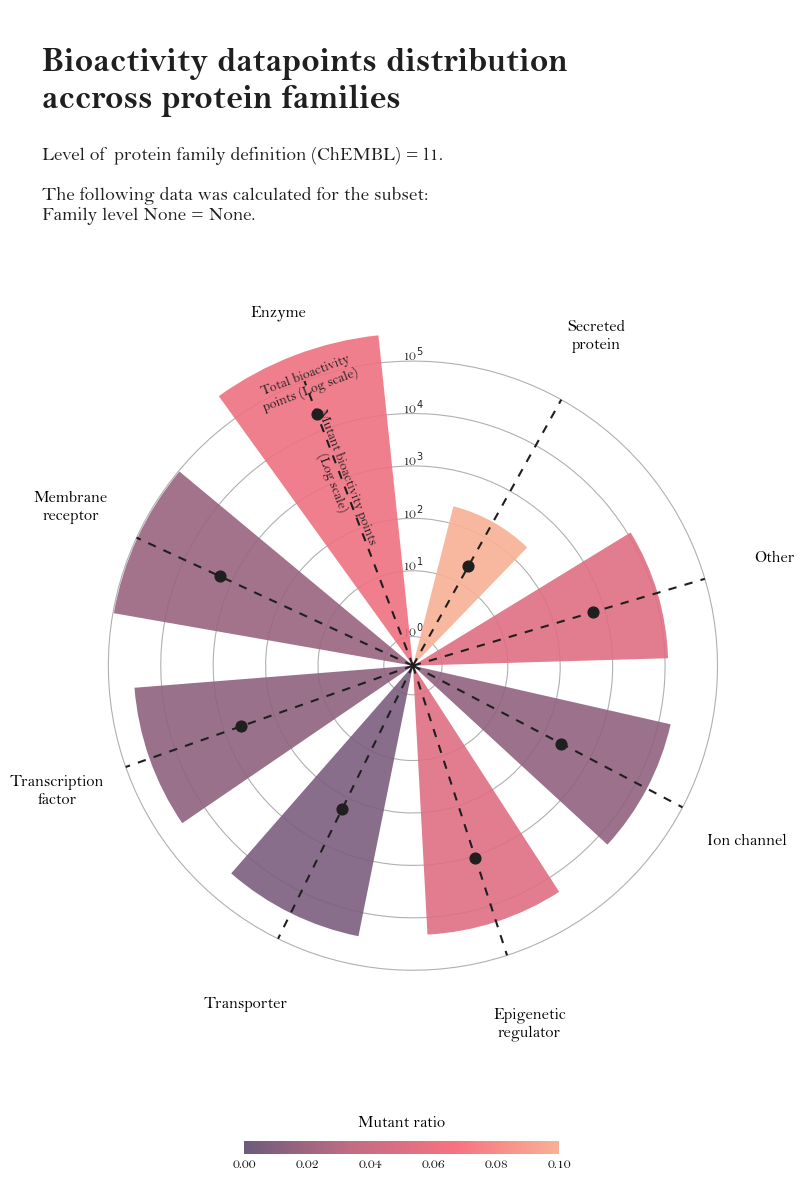

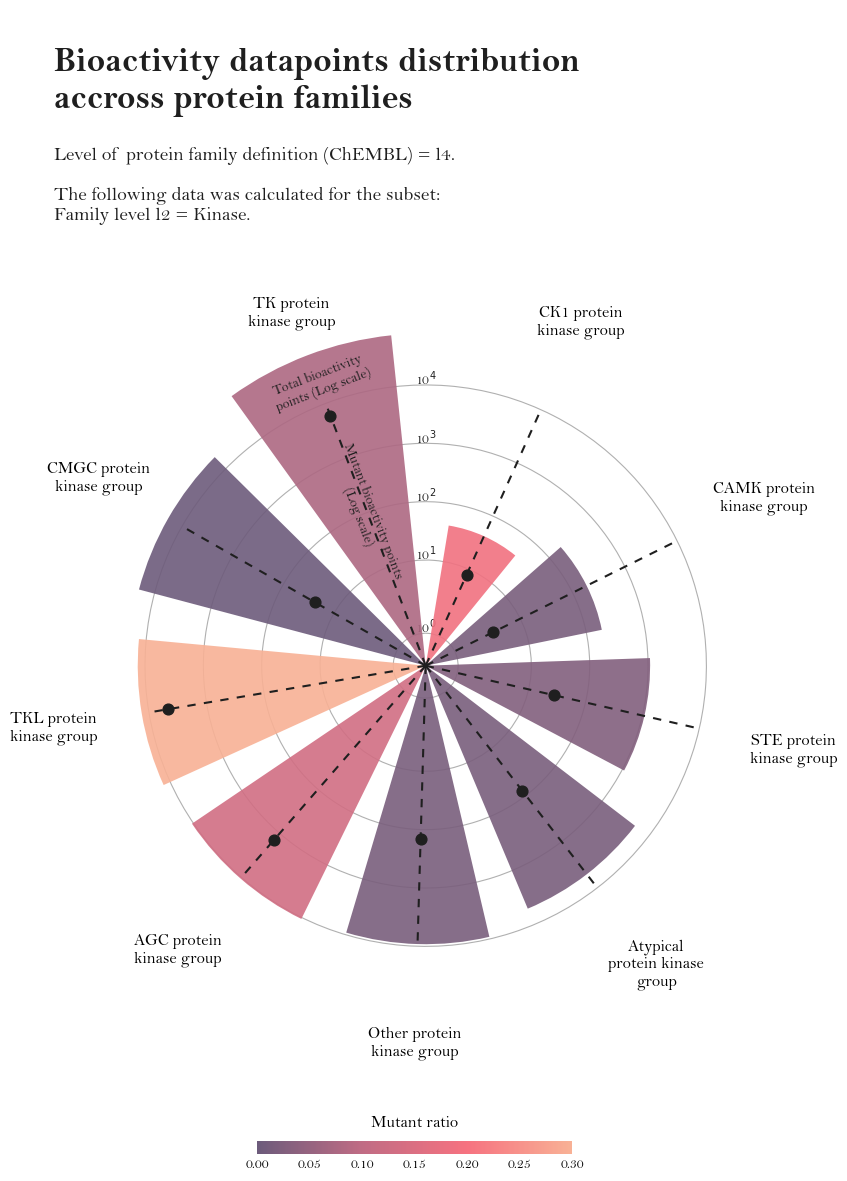

In [22]:
# Bioactivity data
plot_circular_barplot_families(annotated_data_families, 'l1', output_dir, subset_level=None, subset_family=None,
                               save=True, figure_panel=False)
plot_circular_barplot_families(annotated_data_families, 'l4', output_dir, subset_level='l2',
                                       subset_family='Kinase', save=True, figure_panel=False)

                      mut_new  mut_all  mut_ratio
l1                                               
Enzyme                 3663.0    20914   0.175146
Epigenetic regulator     70.0     1174   0.059625
Ion channel               6.0      250   0.024000
Membrane receptor       218.0     1758   0.124005
Other                   103.0      626   0.164537
Transcription factor     42.0      472   0.088983
Transporter               3.0      177   0.016949
Secreted protein          NaN       23   0.000000
                               mut_new  mut_all  mut_ratio
l4                                                        
AGC protein kinase group        1302.0     1452   0.896694
CMGC protein kinase group          4.0       24   0.166667
Other protein kinase group         4.0      116   0.034483
TK protein kinase group          280.0     5485   0.051048
TKL protein kinase group         825.0     4695   0.175719
Atypical protein kinase group      NaN       80   0.000000
CAMK protein kinase group   

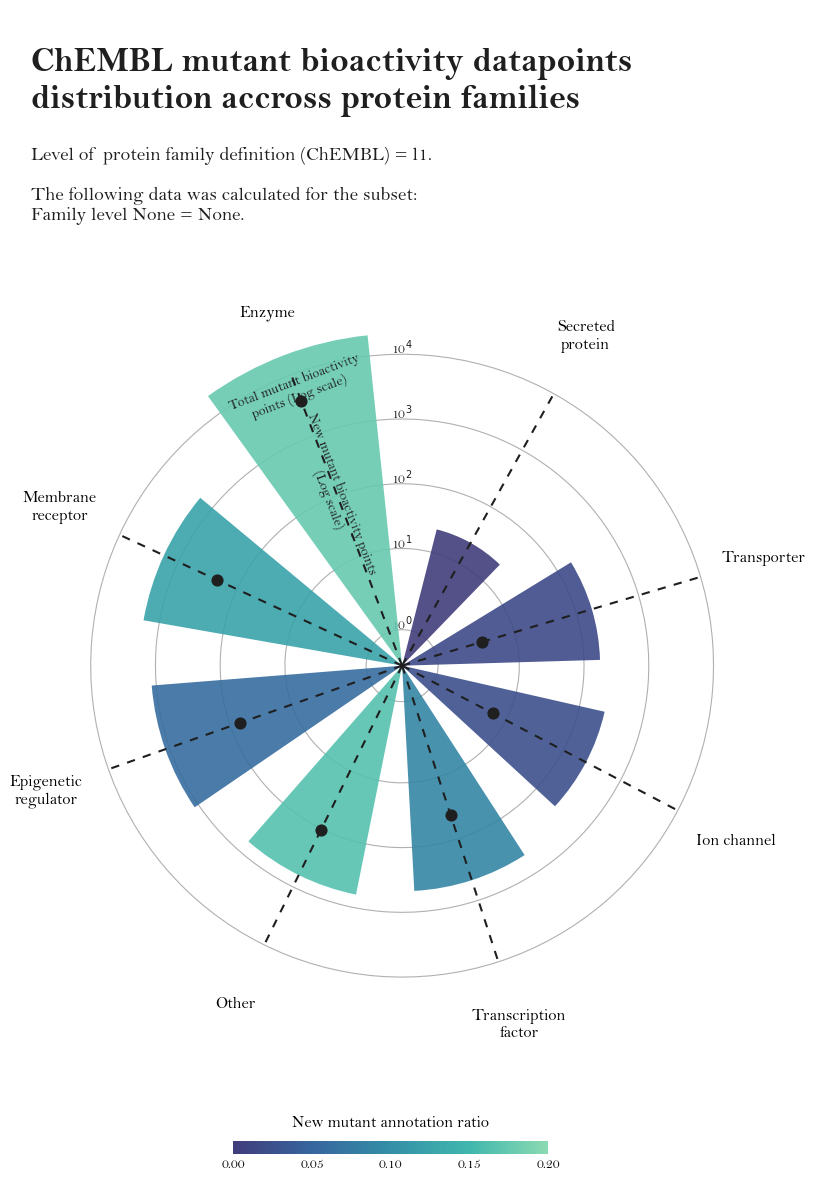

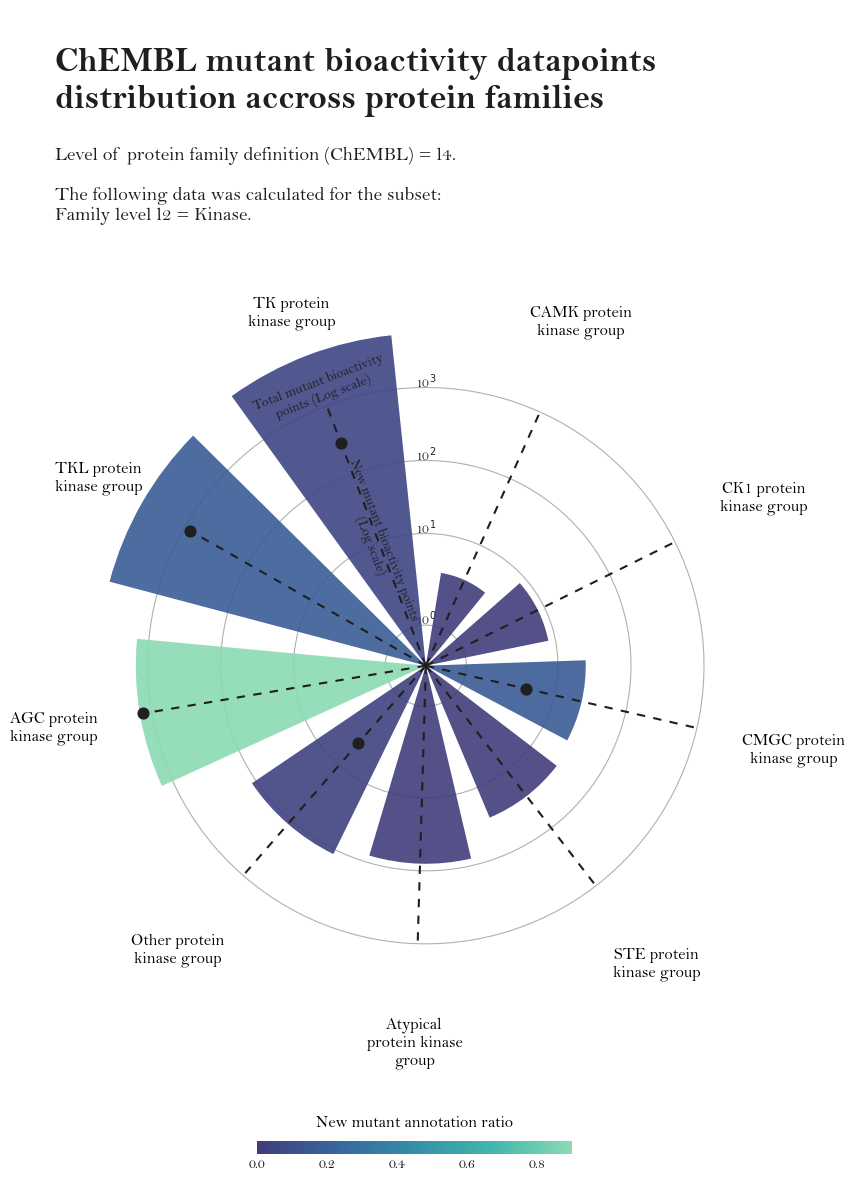

In [23]:
# Mutant annotations
plot_circular_barplot_families_newannotations(chembl_annotated_data_families, 'l1', output_dir,
                                              subset_level=None,subset_family=None,
                                              save=True, figure_panel=False)
plot_circular_barplot_families_newannotations(chembl_annotated_data_families, 'l4', output_dir,
                                              subset_level='l2',subset_family='Kinase',
                                              save=True, figure_panel=False)

#### Quickly check Round 2 target stats

In [24]:
from mutant_analysis_accession import *
output_dir = f'C:\\Users\\gorostiolam\\Documents\\Gorostiola Gonzalez, ' \
             f'Marina\\PROJECTS\\6_Mutants_PCM\\DATA\\2_Analysis\\1_mutant_statistics\\1_target_stats\\round_{annotation_round}'

In [25]:
# Calculate statistics per accession
stats = get_statistics_across_accessions('31', '05.5', 'nostereo', 1_000_000, annotation_round, output_dir, save=True)
stats

,accession,connectivity,connectivity_wt,target_id,connectivity_mutant_percentage,l1,l2,l3,l4,l5,Organism,HGNC_symbol
0,A0A045ISB3,261,245.0,5,6.130268,Enzyme,Hydrolase,Other,Other,Other,Mycobacterium tuberculosis,NaN
1,A2RI47,23,17.0,7,26.086957,Other,Other,Other,Other,Other,Lactococcus lactis subsp. cremoris (strain MG1...,NaN
2,A3EZI9,794,673.0,7,15.239295,Enzyme,Protease,Serine protease,Serine protease PA clan,Serine protease S29 family,Hepacivirus C,NaN
3,A3EZJ3,783,746.0,17,4.725415,Other,Other,Other,Other,Other,Hepacivirus C,NaN
4,A4TVL0,25,22.0,2,12.000000,Other,Other,Other,Other,Other,Magnetospirillum gryphiswaldense,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
330,Q9WKE8,111,0.0,6,100.000000,Enzyme,Other,Other,Other,Other,Human immunodeficiency virus 1,NaN
331,Q9Y243,418,408.0,2,2.392344,Enzyme,Kinase,Protein Kinase,AGC protein kinase group,AGC protein kinase AKT family,Homo sapiens (Human),AKT3
332,Q9Y2R2,279,272.0,8,2.508961,Enzyme,Phosphatase,Protein Phosphatase,Tyrosine protein phosphatase,Other,Homo sapiens (Human),PTPN22
333,Q9Y5X5,129,116.0,7,10.077519,Membrane receptor,GPCR,Peptide receptor (family A GPCR),Short peptide receptor (family A GPCR),RF amide receptor,Homo sapiens (Human),NPFFR2


In [26]:
# Check if relevant targets are more or less the same as in round 1
filter_statistics(stats,
                  min_data=1000,
                  max_data=None,
                  min_percentage=10,
                  max_perccentage=None,
                  min_variants=0,
                  max_variants=None,
                  sort_output_by='connectivity')

Accession codes for filtered accessions (13):
P00533, Q72547, P00519, P15056, P36888, O60885, P10721, Q5S007, Q9UM73, P23443, O75874, P07949, P30968
Gene names for filtered accessions:
EGFR, N/A, ABL1, BRAF;B-Raf, FLT3, BRD4, KIT, LRRK2, ALK, RPS6KB1, IDH1, RET, GNRHR


,accession,connectivity,connectivity_wt,target_id,connectivity_mutant_percentage,l1,l2,l3,l4,l5,Organism,HGNC_symbol
43,P00533,13614,11104.0,13,18.436903,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase EGFR family,Homo sapiens (Human),EGFR
277,Q72547,6953,4590.0,47,33.985330,Enzyme,Hydrolase,Other,Other,Other,Human immunodeficiency virus 1,NaN
40,P00519,4985,3872.0,16,22.326981,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase Abl family,Homo sapiens (Human),ABL1
107,P15056,4740,1883.0,2,60.274262,Enzyme,Kinase,Protein Kinase,TKL protein kinase group,TKL protein kinase RAF family,Homo sapiens (Human),BRAF;B-Raf
176,P36888,4390,3873.0,8,11.776765,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase PDGFR family,Homo sapiens (Human),FLT3
28,O60885,4106,3405.0,6,17.072577,Epigenetic regulator,Reader,Bromodomain,Other,Other,Homo sapiens (Human),BRD4
90,P10721,2897,2334.0,19,19.433897,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase PDGFR family,Homo sapiens (Human),KIT
273,Q5S007,2760,1822.0,4,33.985507,Enzyme,Kinase,Protein Kinase,TKL protein kinase group,TKL protein kinase LRRK family,Homo sapiens (Human),LRRK2
328,Q9UM73,2599,1951.0,12,24.932666,Enzyme,Kinase,Protein Kinase,TKL protein kinase group,TKL protein kinase STKR family,Homo sapiens (Human),ALK
133,P23443,2286,1024.0,3,55.205599,Enzyme,Kinase,Protein Kinase,AGC protein kinase group,AGC protein kinase RSK family,Homo sapiens (Human),RPS6KB1


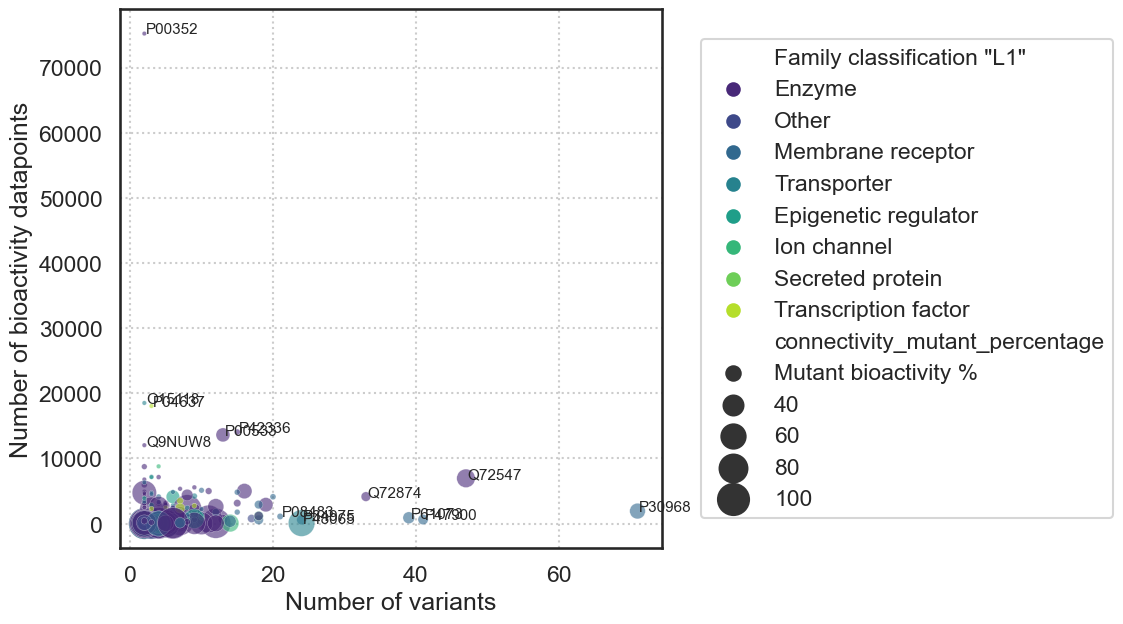

In [27]:
# Plot statistics
plot_stats_bubble(stats,
                  filter_tag='',
                  hue_property='l1',
                  hue_title='Family classification "L1"',
                  label_condition='connectivity',
                  xy_lims=None,
                  output_dir=output_dir,
                  save=True)

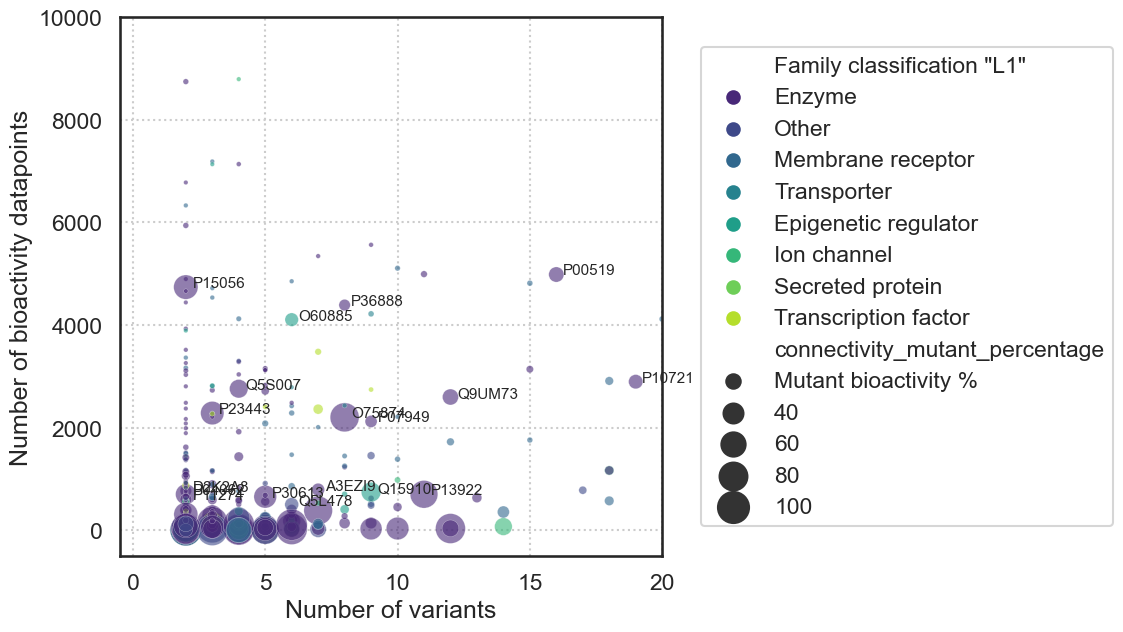

In [28]:
# Zoom into the most populated area
plot_stats_bubble(stats,
                  filter_tag='',
                  hue_property='l1',
                  hue_title='Family classification "L1"',
                  label_condition='connectivity_mutant_percentage',
                  xy_lims=[(-0.5,20),(-500,10000)],
                  output_dir=output_dir,
                  save=True)

In [29]:
# Get statistics across variants
stats_variant = get_statistics_across_variants('31', '05.5', 'nostereo', 1_000_000, annotation_round, output_dir,
                                               save=True)
stats_variant

,accession,variant,connectivity_variant,connectivity,connectivity_wt,target_id,connectivity_mutant_percentage,l1,l2,l3,l4,l5,Organism,HGNC_symbol,connectivity_variant_percentage,variant_order,connectivity_variant_fold
0,A0A045ISB3,A0A045ISB3_F161S,4,261,245.0,5,6.130268,Enzyme,Hydrolase,Other,Other,Other,Mycobacterium tuberculosis,NaN,1.532567,2,61.250000
1,A0A045ISB3,A0A045ISB3_I203A,4,261,245.0,5,6.130268,Enzyme,Hydrolase,Other,Other,Other,Mycobacterium tuberculosis,NaN,1.532567,3,61.250000
2,A0A045ISB3,A0A045ISB3_I207A,4,261,245.0,5,6.130268,Enzyme,Hydrolase,Other,Other,Other,Mycobacterium tuberculosis,NaN,1.532567,5,61.250000
3,A0A045ISB3,A0A045ISB3_I207K,4,261,245.0,5,6.130268,Enzyme,Hydrolase,Other,Other,Other,Mycobacterium tuberculosis,NaN,1.532567,4,61.250000
4,A0A045ISB3,A0A045ISB3_WT,245,261,245.0,5,6.130268,Enzyme,Hydrolase,Other,Other,Other,Mycobacterium tuberculosis,NaN,93.869732,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,Q9YQ12,Q9YQ12_V32I_L33F_I54M_V82I,2,1168,1092.0,18,6.506849,Enzyme,Protease,Cysteine protease,Cysteine protease PAC clan,Cysteine protease C3A subfamily,Human immunodeficiency virus 1,NaN,0.171233,8,546.000000
1748,Q9YQ12,Q9YQ12_V32I_M46I_I47V_Q58E_I84V,11,1168,1092.0,18,6.506849,Enzyme,Protease,Cysteine protease,Cysteine protease PAC clan,Cysteine protease C3A subfamily,Human immunodeficiency virus 1,NaN,0.941781,4,99.272727
1749,Q9YQ12,Q9YQ12_V82A,4,1168,1092.0,18,6.506849,Enzyme,Protease,Cysteine protease,Cysteine protease PAC clan,Cysteine protease C3A subfamily,Human immunodeficiency virus 1,NaN,0.342466,5,273.000000
1750,Q9YQ12,Q9YQ12_V82F,3,1168,1092.0,18,6.506849,Enzyme,Protease,Cysteine protease,Cysteine protease PAC clan,Cysteine protease C3A subfamily,Human immunodeficiency virus 1,NaN,0.256849,6,364.000000


In [30]:
# Filter variants in proteins with relevant amount of data
stats_variant_filtered = filter_statistics(stats_variant,
                                           min_data=1000,
                                           max_data=None,
                                           min_percentage=10,
                                           max_perccentage=None,
                                           min_variants=0,
                                           max_variants=None,
                                           sort_output_by='connectivity_mutant_percentage')
variants_filter_tag = 'C1000P10' # To identify in the upcoming plots that the stats were filtered
stats_variant_filtered

Accession codes for filtered accessions (13):
O75874, P15056, P23443, Q5S007, Q72547, Q9UM73, P30968, P00519, P10721, P00533, O60885, P07949, P36888
Gene names for filtered accessions:
IDH1, BRAF;B-Raf, RPS6KB1, LRRK2, N/A, ALK, GNRHR, ABL1, KIT, EGFR, BRD4, RET, FLT3


,accession,variant,connectivity_variant,connectivity,connectivity_wt,target_id,connectivity_mutant_percentage,l1,l2,l3,l4,l5,Organism,HGNC_symbol,connectivity_variant_percentage,variant_order,connectivity_variant_fold
128,O75874,O75874_R132L,11,2203,302.0,8,86.291421,Enzyme,Oxidoreductase,Other,Other,Other,Homo sapiens (Human),IDH1,0.499319,5,134.090909
126,O75874,O75874_R132H,1475,2203,302.0,8,86.291421,Enzyme,Oxidoreductase,Other,Other,Other,Homo sapiens (Human),IDH1,66.954153,1,1.000000
130,O75874,O75874_WT,302,2203,302.0,8,86.291421,Enzyme,Oxidoreductase,Other,Other,Other,Homo sapiens (Human),IDH1,13.708579,3,4.884106
129,O75874,O75874_R132S,5,2203,302.0,8,86.291421,Enzyme,Oxidoreductase,Other,Other,Other,Homo sapiens (Human),IDH1,0.226963,7,295.000000
127,O75874,O75874_R132H_R132C,94,2203,302.0,8,86.291421,Enzyme,Oxidoreductase,Other,Other,Other,Homo sapiens (Human),IDH1,4.266909,4,15.691489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,P36888,P36888_F691L,38,4390,3873.0,8,11.776765,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase PDGFR family,Homo sapiens (Human),FLT3,0.865604,6,101.921053
923,P36888,P36888_K663Q,52,4390,3873.0,8,11.776765,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase PDGFR family,Homo sapiens (Human),FLT3,1.184510,5,74.480769
924,P36888,P36888_N841I,70,4390,3873.0,8,11.776765,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase PDGFR family,Homo sapiens (Human),FLT3,1.594533,4,55.328571
925,P36888,P36888_R834Q,38,4390,3873.0,8,11.776765,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase PDGFR family,Homo sapiens (Human),FLT3,0.865604,7,101.921053


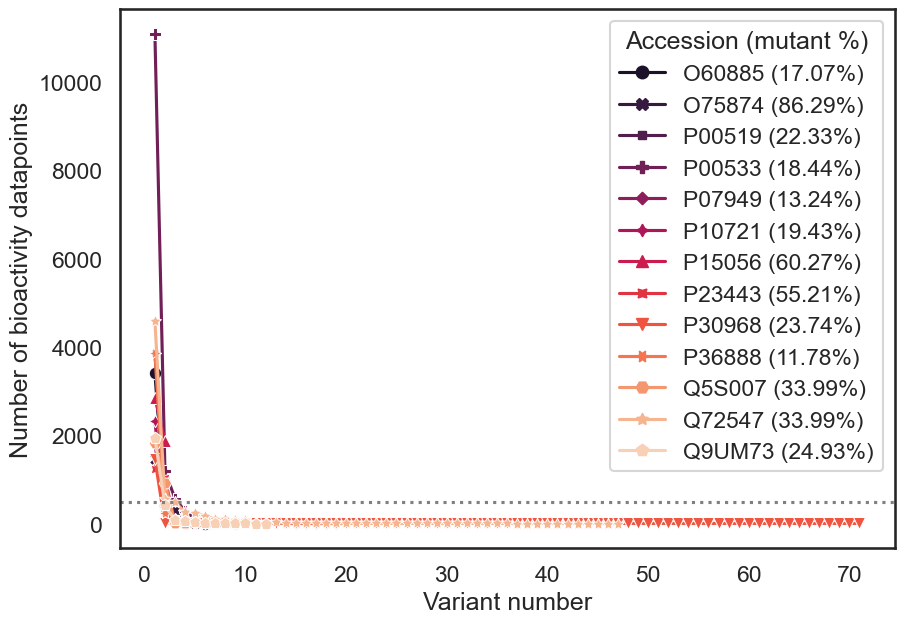

In [31]:
# Plot amount of data in each variant for selected proteins
plot_variant_stats_lineplot(stats_variant_filtered,
                            filter_tag=variants_filter_tag,
                            y_column='connectivity_variant',
                            y_label='Number of bioactivity datapoints',
                            xy_lims=None,
                            output_dir=output_dir,
                            save=True
                            )

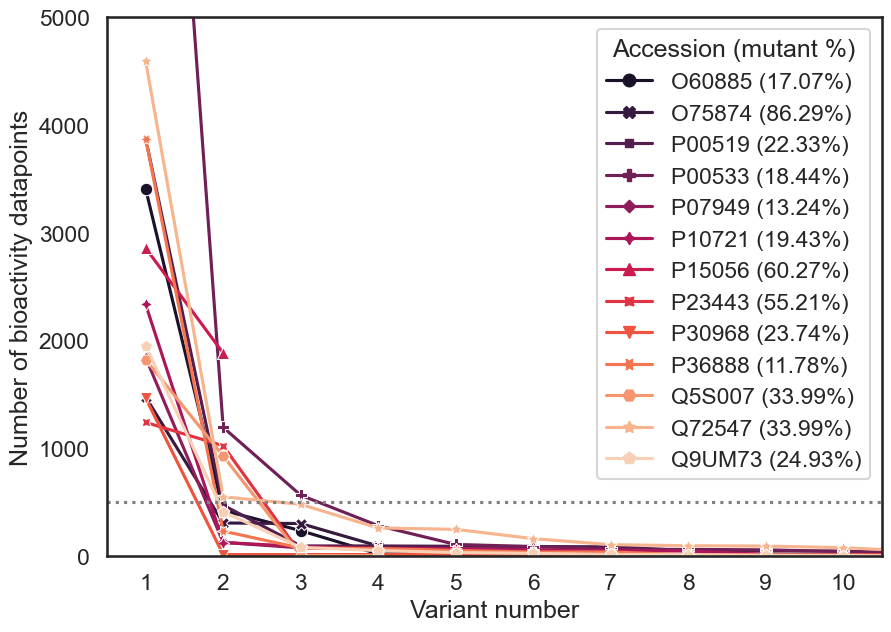

In [32]:
# Plot zooming in
plot_variant_stats_lineplot(stats_variant_filtered,
                            filter_tag=variants_filter_tag,
                            y_column='connectivity_variant',
                            y_label='Number of bioactivity datapoints',
                            xy_lims=[(0.5,10.5),(0,5000)],
                            output_dir=output_dir,
                            save=True
                            )

#### Quick check stats per mutant type

In [36]:
from mutant_analysis_type import plot_heatmap_aa_change,map_aa_change
output_dir = 'C:\\Users\\gorostiolam\\Documents\\Gorostiola Gonzalez, ' \
             f'Marina\\PROJECTS\\6_Mutants_PCM\\DATA\\2_Analysis\\1_mutant_statistics\\2_mutation_type\\round_{annotation_round}'

In [38]:
mutation_types = map_aa_change(combined_dataset, direction=True)
mutation_types[mutation_types['aa_change'] == 'MT']

,target_id,connectivity,pchembl_value_Mean,Activity_class_consensus,source,SMILES,CID,accession,sequence,Year,UniProtID,Organism,HGNC_symbol,mutation_type,aa_change
127009,P00519_M351T,AAKJLRGGTJKAMG,6.640,"Series([], dtype: object)",ChEMBL31;Papyrus05.5_Christmann2016,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,CHEMBL553,P00519,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,2005.0,ABL1_HUMAN,Homo sapiens (Human),ABL1,polar_size,MT
127010,P00519_M351T,ACPOUJIDANTYHO,5.000,"Series([], dtype: object)",Papyrus05.5_Christmann2016,O=C1c2c(cccc2)-c2c3c1cccc3n[nH]2,Christmann2016.compound.90,P00519,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,2005.0,ABL1_HUMAN,Homo sapiens (Human),ABL1,polar_size,MT
127011,P00519_M351T,BCFGMOOMADDAQU,5.000,"Series([], dtype: object)",Papyrus05.5_Christmann2016,CS(=O)(=O)CCNCc1ccc(-c2cc3c(cc2)ncnc3Nc2cc(Cl)...,Christmann2016.compound.52,P00519,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,2005.0,ABL1_HUMAN,Homo sapiens (Human),ABL1,polar_size,MT
127012,P00519_M351T,BIIVYFLTOXDAOV,5.480,"Series([], dtype: object)",ChEMBL31;Papyrus05.5_Christmann2016,CN1CC[C@H](c2c(O)cc(O)c3c(=O)cc(-c4ccccc4Cl)oc...,CHEMBL428690,P00519,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,2005.0,ABL1_HUMAN,Homo sapiens (Human),ABL1,polar_size,MT
127013,P00519_M351T,BJCJYEYYYGBROF,7.660,"Series([], dtype: object)",ChEMBL31,Cc1ncc(NC(=O)c2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,CHEMBL3545413,P00519,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,2019.0,ABL1_HUMAN,Homo sapiens (Human),ABL1,polar_size,MT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322765,P30968_M24T,UCQSBGOFELXYIN,6.710,"Series([], dtype: object)",ChEMBL31,CONC(=O)Nc1ccc(-c2sc3c(c2CN(C)Cc2ccccc2)c(=O)n...,CHEMBL22055,P30968,MANSASPEQNQNHCSAINNSIPLTQGNLPTLTLSGKIRVTVTFFLF...,2006.0,GNRHR_HUMAN,Homo sapiens (Human),GNRHR,polar_size,MT
322766,P30968_M24T,WEEHADTZCAHCEM,8.480,"Series([], dtype: object)",ChEMBL31,CC(C)C[C@H](NC(=O)CNC(=O)[C@H](Cc1ccc(O)cc1)NC...,CHEMBL3085508,P30968,MANSASPEQNQNHCSAINNSIPLTQGNLPTLTLSGKIRVTVTFFLF...,2006.0,GNRHR_HUMAN,Homo sapiens (Human),GNRHR,polar_size,MT
504676,Q923Y9_M268T,BHHGXPLMPWCGHP,6.580,"Series([], dtype: object)",ChEMBL31,NCCc1ccccc1,CHEMBL610,Q923Y9,MHLCHNSANISHTNSNWSRDVRASLYSLISLIILTTLVGNLIVIIS...,2014.0,TAAR1_RAT,Rattus norvegicus (Rat),TAAR1,polar_size,MT
504677,Q923Y9_M268T,KWTSXDURSIMDCE,6.420,"Series([], dtype: object)",ChEMBL31,C[C@@H](N)Cc1ccccc1,CHEMBL19393,Q923Y9,MHLCHNSANISHTNSNWSRDVRASLYSLISLIILTTLVGNLIVIIS...,2014.0,TAAR1_RAT,Rattus norvegicus (Rat),TAAR1,polar_size,MT


In [39]:
# Plot heatmaps with amino acid change counts
plot_heatmap_aa_change(combined_dataset, output_dir, 'variant', None, None)
plot_heatmap_aa_change(combined_dataset, output_dir, 'activity', None, None)

#### Quickly check stats per organism and mutant type

In [40]:
from mutant_analysis_organism import annotate_organism_taxonomy
from mutant_analysis_type import plot_bubble_aachange_distance,plot_stacked_bars_mutation_type
output_dir = f'C:\\Users\\gorostiolam\\Documents\\Gorostiola Gonzalez, ' \
             f'Marina\\PROJECTS\\6_Mutants_PCM\\DATA\\2_Analysis\\1_mutant_statistics\\2_mutation_type\\round_{annotation_round}'
dist_dir = 'C:\\Users\\gorostiolam\\Documents\\Gorostiola Gonzalez, ' \
               'Marina\\PROJECTS\\6_Mutants_PCM\\DATA\\2_Analysis\\1_mutant_statistics\\2_mutation_type' \
               '\\mutation_distances'

In [41]:
# Annotated data with organism taxonomy
annotated_data_tax = annotate_organism_taxonomy(combined_dataset)

Fetched: 306 / 335


C:\Users\gorostiolam\Documents\Gorostiola Gonzalez, Marina\PROJECTS\6_Mutants_PCM\PROTOCOLS-SCRIPTS\Python\mutants-in-pcm\src\mutants-in-pcm\mutant_analysis_type.py:475: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(os.path.join(output_dir, out_file))
C:\Users\gorostiolam\Documents\Gorostiola Gonzalez, Marina\PROJECTS\6_Mutants_PCM\PROTOCOLS-SCRIPTS\Python\mutants-in-pcm\src\mutants-in-pcm\mutant_analysis_type.py:475: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(os.path.join(output_dir, out_file))
C:\Users\gorostiolam\Documents\Gorostiola Gonzalez, Marina\PROJECTS\6_Mutants_PCM\PROTOCOLS-SCRIPTS\Python\mutants-in-pcm\src\mutants-in-pcm\mutant_analysis_type.py:475: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decoration

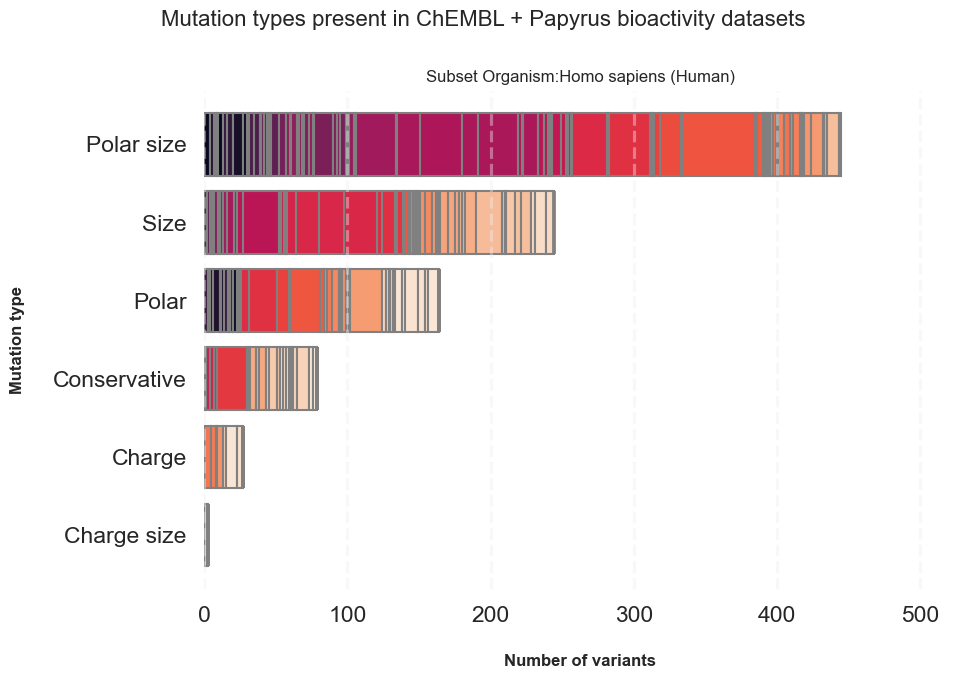

C:\Users\gorostiolam\AppData\Local\Continuum\anaconda3\envs\mutants-in-pcm\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


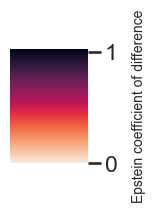

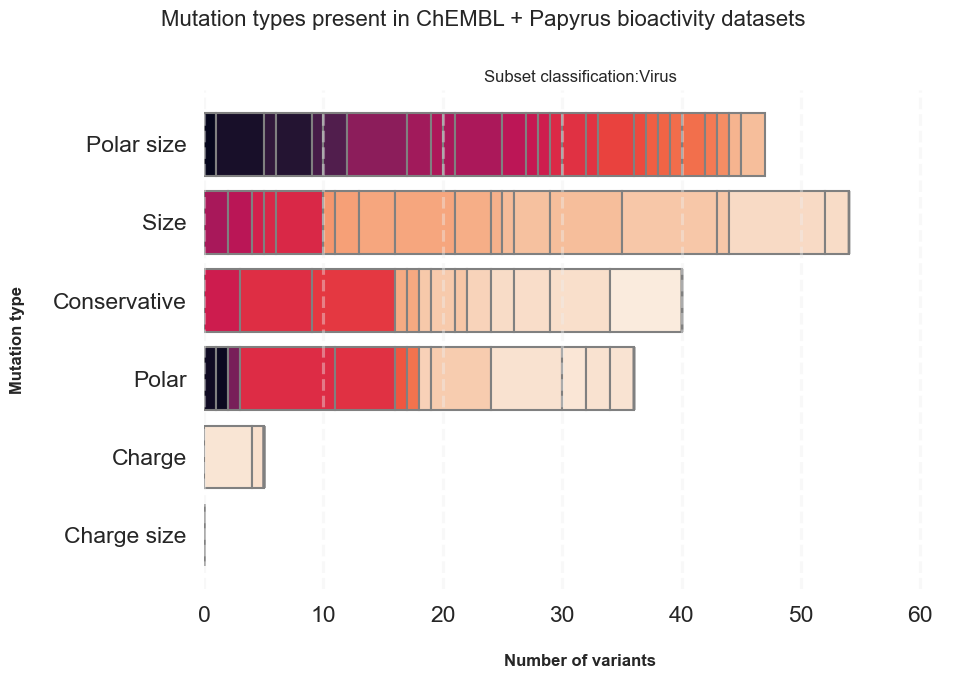

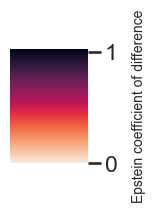

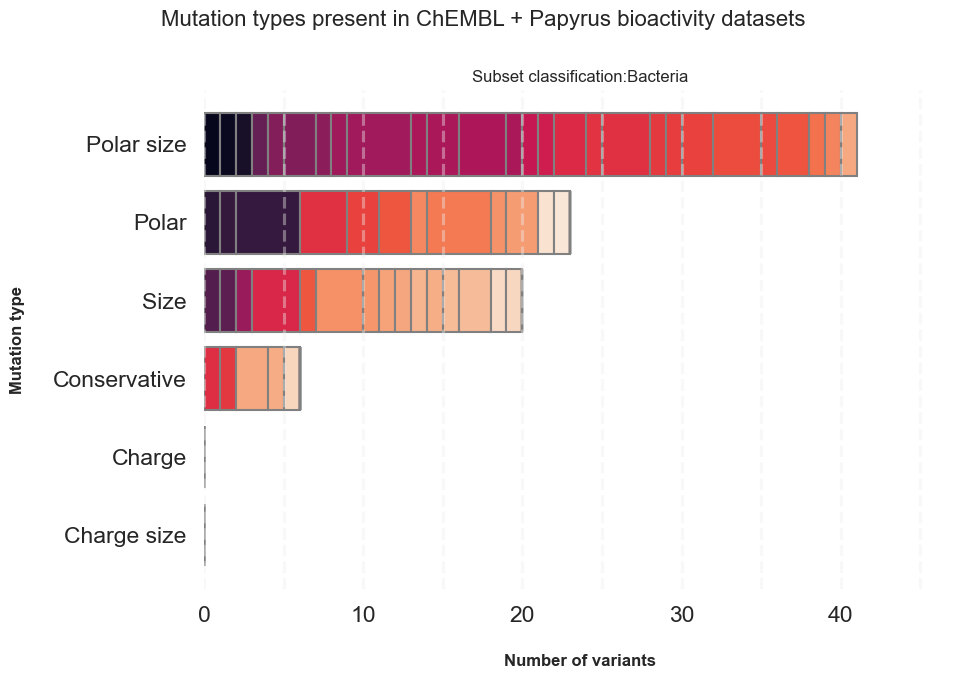

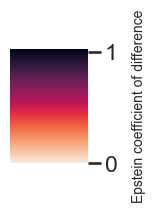

In [42]:
# Plot stack bars for human/virus/bacteria
plot_stacked_bars_mutation_type(annotated_data_tax, os.path
                                .join(output_dir, 'organism'),
                                True, 'variant', 'distance_matrix', 'Organism', 'Homo sapiens (Human)', False)
plot_stacked_bars_mutation_type(annotated_data_tax, os.path
                                .join(output_dir, 'organism'),
                                True, 'variant', 'distance_matrix', 'classification', 'Virus', False)
plot_stacked_bars_mutation_type(annotated_data_tax, os.path
                                .join(output_dir, 'organism'),
                                True, 'variant', 'distance_matrix', 'classification', 'Bacteria', False)

Fetched: 5 / 5
Reading pre-computed results...
{'2JLE': {'ligand': 'I15', 'chain': 'A', 'distance': {'1': 26.398, '2': 28.465, '3': 26.002, '4': 28.065, '5': 26.236, '6': 29.256, '7': 30.737, '8': 29.01, '9': 32.306, '10': 32.799, '11': 36.357, '12': 38.087, '13': 37.371, '14': 40.962, '15': 43.979, '16': 42.02, '17': 43.644, '18': 42.048, '19': 41.058, '20': 45.518, '21': 43.31, '22': 47.229, '23': 44.424, '24': 44.472, '25': 47.968, '26': 44.793, '27': 45.915, '28': 49.063, '29': 44.011, '30': 41.852, '31': 44.53, '32': 44.027, '33': 39.684, '34': 39.172, '35': 41.748, '36': 38.819, '37': 35.521, '38': 37.551, '39': 39.208, '40': 34.828, '41': 33.383, '42': 38.377, '43': 36.549, '44': 32.184, '45': 33.649, '46': 30.877, '47': 35.561, '48': 38.856, '49': 43.24, '50': 44.053, '51': 47.373, '52': 50.287, '53': 50.23, '54': 45.101, '55': 46.765, '56': 43.474, '57': 42.485, '58': 38.736, '59': 39.415, '60': 38.763, '61': 38.014, '62': 37.221, '63': 35.001, '64': 36.339, '65': 35.639, '66'

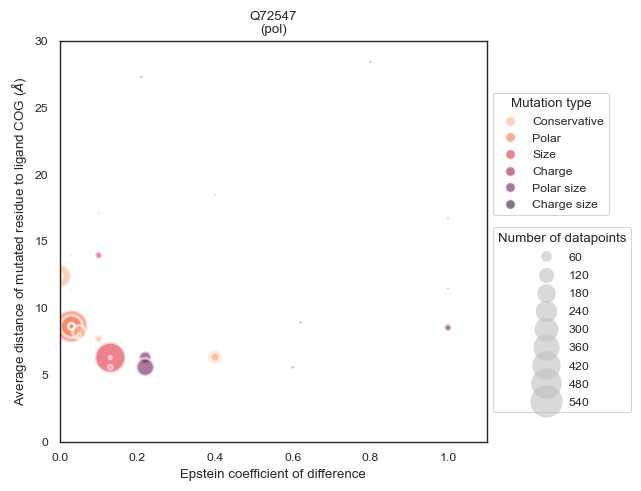

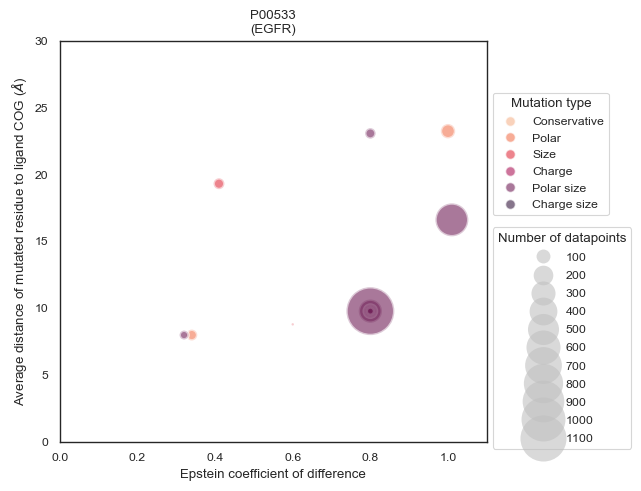

In [43]:
# Plot bubble plots for EGFR and HIV
hiv_accession_list = combined_dataset[combined_dataset['Organism'].str.contains('Human immunodeficiency virus 1', na=False)]['accession'].unique().tolist()
plot_bubble_aachange_distance(combined_dataset, hiv_accession_list, 'HIV', dist_dir,
                              output_dir, True, True)
plot_bubble_aachange_distance(combined_dataset, ['P00533'], 'EGFR', dist_dir,
                              output_dir, True,True)

#### Quickly check EGFR as case study

In [60]:
from mutant_analysis_common_subsets import compute_variant_activity_distribution,read_common_subset
from mutant_analysis_clustermaps import extract_unique_connectivity,pivot_bioactivity_data,plot_bioactivity_heatmap,\
    plot_bioactivity_clustermap,extract_oldest_year
from mutant_analysis_type import read_mutation_distance_Epstein
from mutant_analysis_compounds import butina_cluster_compounds
output_dir = f'C:\\Users\\gorostiolam\\Documents\\Gorostiola Gonzalez, ' \
                 f'Marina\\PROJECTS\\6_Mutants_PCM\\DATA\\2_Analysis\\1_mutant_statistics\\3_common_subset\\round_{annotation_round}'

##### Check how many deletions are there

In [61]:
# Reload annotations of false positives and negatives from round 1 and keep only deletion flags for EGFR
false_negative_full = pd.read_csv('../../data/chembl31_rejected_assays_round1.csv', sep='\t',usecols =['assay_id',
                                                                                                   'accession',
                                                                                                   'rejection_flag'])
false_positive_full = pd.read_csv('../../data/chembl31_wrong_annotated_assays_round1.csv', sep='\t',usecols
=['assay_id',
                                                                                                   'accession',
                                                                                                    'reason',
                                                                                                   'group_reason'])
false_negative_deletions = false_negative_full[false_negative_full['rejection_flag'] == 'original_deletion']
false_positive_deletions = false_positive_full[false_positive_full['reason'] == 'missing deletion']
egfr_deletions = pd.concat([false_positive_deletions[false_positive_deletions['accession']=='P00533'][['assay_id',
                                                                                                       'accession']],
                            false_negative_deletions[false_negative_deletions['accession']=='P00533'][['assay_id',
                                                                                                  'accession']]])
egfr_deletions['deletion'] = True

In [62]:
# Attach deletion flags to round 2 assays (with updated target_id)
chembl_assays_with_egfr_deletions = pd.merge(round2_assays[round2_assays['accession']=='P00533'], egfr_deletions,
                                             how='left',on=['assay_id','accession']).fillna(False)
# Check how many assays (from ChEMBL) have hidden deletions per EGFR annotated mutation
chembl_assays_with_egfr_deletions.groupby(['target_id','deletion'])['assay_id'].count()

target_id                 deletion
P00533_A750P              False          2
                          True          26
P00533_C797S              False          7
P00533_C797S_L858R        False          2
P00533_G719C              False         30
P00533_G719S              False         30
P00533_L858R              False        176
                          True           1
P00533_L861Q              False         58
P00533_P753S              False          2
                          True          25
P00533_T790M              False        106
                          True          15
P00533_T790M_C797S        False          2
                          True           5
P00533_T790M_C797S_L858R  False         30
P00533_T790M_L858M        False          1
P00533_T790M_L858R        False        293
P00533_T790M_L861R        False          1
P00533_WT                 False       1810
Name: assay_id, dtype: int64

In [63]:
# Attach ChEMBL data to round 2 assays with deletion flags
chembl_data = obtain_chembl_data('31')
# Not possible to ChEMBL + Papyrus round 2 (combined_dataset) because it does not have assay_id variable anymore
chembl_data_with_egfr_deletions = pd.merge(chembl_data[chembl_data['accession']=='P00533'][['assay_id','accession',
                                                                                            'chembl_id','mutation']],
                                           chembl_assays_with_egfr_deletions[['assay_id','accession','target_id',
                                                                              'deletion']],
                                           how='left',on=['assay_id','accession']).fillna(False)
# Check how many activity datapoints (from ChEMBL) have hidden deletions per EGFR annotated mutation
chembl_data_with_egfr_deletions.groupby(['target_id','deletion'])['chembl_id'].count()

C:\Users\gorostiolam\AppData\Local\Continuum\anaconda3\envs\mutants-in-pcm\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (4,6,7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  


target_id                 deletion
P00533_A750P              False          20
                          True           62
P00533_C797S              False          30
P00533_C797S_L858R        False          34
P00533_G719C              False          91
P00533_G719S              False          82
P00533_L858R              False        1704
                          True            1
P00533_L861Q              False         901
P00533_P753S              False          18
                          True           58
P00533_T790M              False        1144
                          True          108
P00533_T790M_C797S        False           5
                          True           20
P00533_T790M_C797S_L858R  False         145
P00533_T790M_L858M        False          30
P00533_T790M_L858R        False        2757
P00533_T790M_L861R        False           1
P00533_WT                 False       14100
Name: chembl_id, dtype: int64

##### Common subsets

In [64]:
# Compute common subset
for accession in ['P00533']:
    compute_variant_activity_distribution(combined_dataset, accession, common=False, sim=False, sim_thres=None,
                                              threshold=None, variant_coverage=None, plot=True, hist=False, plot_mean=True,
                                              color_palette=None,save_dataset=True,output_dir=os.path.join(output_dir,
                                                                                                       'all'))
    # Strict common subset with > 20% coverage
    compute_variant_activity_distribution(combined_dataset, accession, common=True, sim=False, sim_thres=None,
                                       threshold=2,variant_coverage=0.2, plot=True, hist=False, plot_mean=True,
                                       color_palette=None,save_dataset=False, output_dir=os.path.join(output_dir,'common_subset_20'))
    # Common subset with > 20% coverage including similar compounds (>80% Tanimoto) tested in other variants
    compute_variant_activity_distribution(combined_dataset, accession, common=True, sim=True, sim_thres=0.8,
                                       threshold=2,variant_coverage=0.2, plot=True, hist=False, plot_mean=True,
                                       color_palette=None,save_dataset=False, output_dir=os.path.join(output_dir,'common_subset_20_sim_80'))
    # Strictly common subset (threshold=None)
    compute_variant_activity_distribution(combined_dataset, accession, common=True, sim=False, sim_thres=None,
                                         threshold=None,variant_coverage=None, plot=True, hist=False, plot_mean=True,
                                            color_palette=None,save_dataset=False, output_dir=os.path.join(
            output_dir,'strict_common_subset'))

P00533 already plotted and statistics analyzed. Skipping...
P00533 already plotted and statistics analyzed. Skipping...
P00533 already plotted and statistics analyzed. Skipping...
Skipping accession P00533: not enough data for plotting.


##### Clustermaps

In [65]:
# Plot clustermaps
accession = 'P00533'
preferred_common_subset = 'all'
common_subset_args = {'all':{'common':False,
                             'sim':False,
                             'sim_thres':None,
                             'threshold':None,
                             'variant_coverage':None},
                      'common_subset_20_sim_80':{'common':True,
                                                 'sim':True,
                                                 'sim_thres':0.8,
                                                 'threshold':2,
                                                 'variant_coverage':0.2}}
# Read common subset
common_subset = read_common_subset(accession,output_dir=os.path.join(output_dir,preferred_common_subset),
                                   **common_subset_args[preferred_common_subset])
# Pivot strictly common subset for clustermap plotting
strictly_common_subset_df = pivot_bioactivity_data(common_subset, True, 3, 0.1)
strictly_common_subset_list = extract_unique_connectivity(strictly_common_subset_df, pivoted=True)

total # clusters:  8
# clusters with only 1 compound:  5
# clusters with >5 compounds:  1
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0


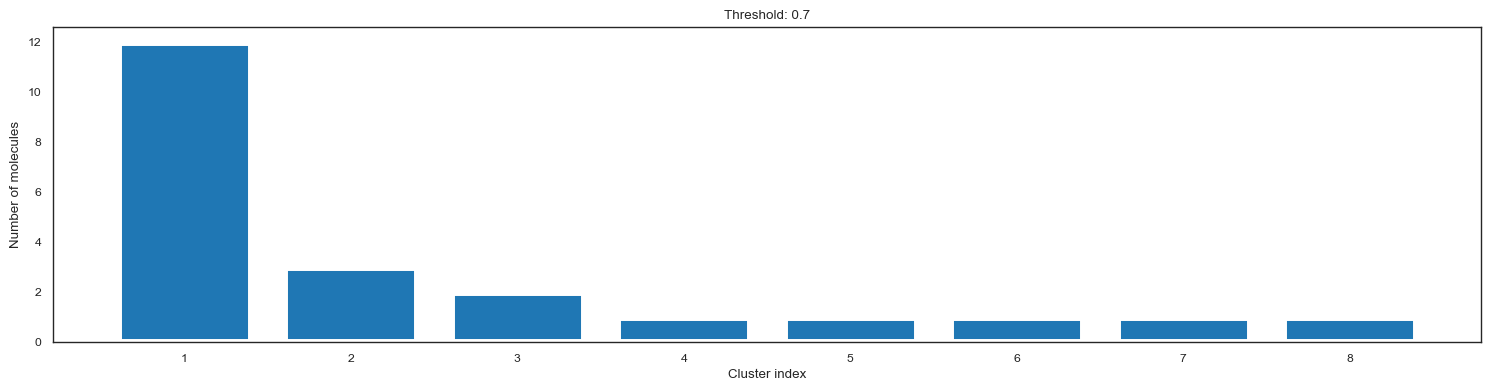

In [66]:
# Cluster compounds with Butina algorithm
accession_data = filter_accession_data(combined_dataset, accession)
clusters,compounds,connectivity_cluster_dict = butina_cluster_compounds(accession, accession_data, strictly_common_subset_list,
                                                                        'strictly_common_subset', os.path.join
                                                                        (output_dir,'clustermaps'), 0.65)

C:\Users\gorostiolam\Documents\Gorostiola Gonzalez, Marina\PROJECTS\6_Mutants_PCM\PROTOCOLS-SCRIPTS\Python\mutants-in-pcm\src\mutants-in-pcm\mutant_analysis_clustermaps.py:168: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(os.path.join(output_dir, f'clustermap_{accession}_ButinaCluster_groups.svg'))
C:\Users\gorostiolam\AppData\Local\Continuum\anaconda3\envs\mutants-in-pcm\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


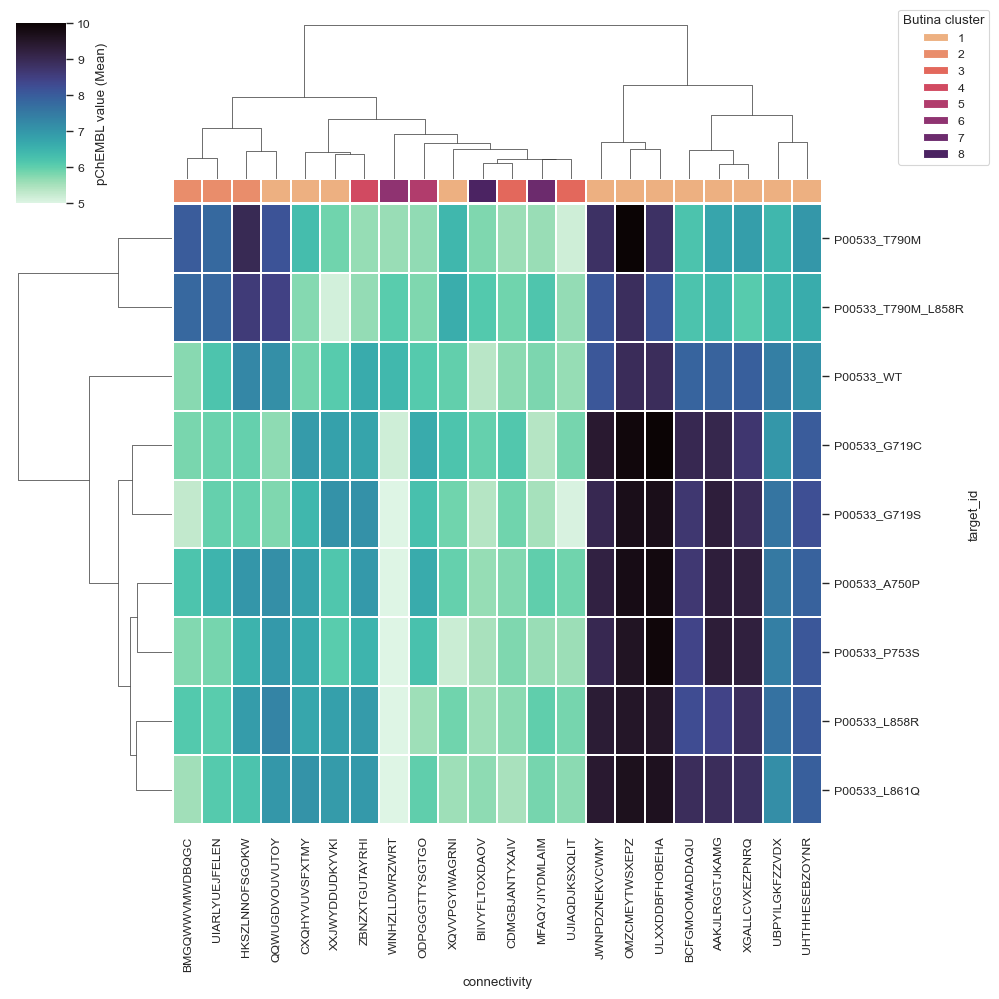

In [67]:
# Plot clustermap with butina codes
plot_bioactivity_clustermap(accession, strictly_common_subset_df, 'butina_clusters', None, os.path.join(output_dir,
                                                                                           'clustermaps'),
                            **{'connectivity_cluster_dict':connectivity_cluster_dict})

Reading pre-computed results...
{'1M17': {'ligand': 'AQ4', 'chain': 'A', 'distance': {'672': 36.457, '673': 32.553, '674': 31.168, '675': 30.997, '676': 25.817, '677': 28.573, '678': 23.664, '679': 23.341, '680': 20.822, '681': 20.4, '682': 21.338, '683': 18.391, '684': 22.415, '685': 19.368, '686': 22.128, '687': 20.424, '688': 15.927, '689': 17.796, '690': 13.992, '691': 13.838, '692': 11.135, '693': 10.063, '694': 5.868, '695': 7.906, '696': 11.385, '697': 11.827, '698': 14.183, '699': 10.899, '700': 11.837, '701': 10.164, '702': 5.894, '703': 9.876, '704': 9.019, '705': 11.135, '706': 14.7, '707': 16.522, '708': 19.752, '709': 21.349, '710': 26.402, '711': 26.939, '712': 25.237, '713': 25.421, '714': 21.252, '715': 19.02, '716': 15.227, '717': 12.093, '718': 9.853, '719': 6.812, '720': 9.24, '721': 8.587, '722': 12.721, '723': 14.964, '724': 17.822, '725': 20.588, '726': 21.614, '727': 22.86, '728': 21.695, '729': 24.291, '730': 22.573, '731': 18.906, '732': 20.305, '733': 22.088, 

C:\Users\gorostiolam\Documents\Gorostiola Gonzalez, Marina\PROJECTS\6_Mutants_PCM\PROTOCOLS-SCRIPTS\Python\mutants-in-pcm\src\mutants-in-pcm\mutant_analysis_clustermaps.py:257: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(output_dir, f'clustermap_{accession}_distance_groups_legend.svg'))


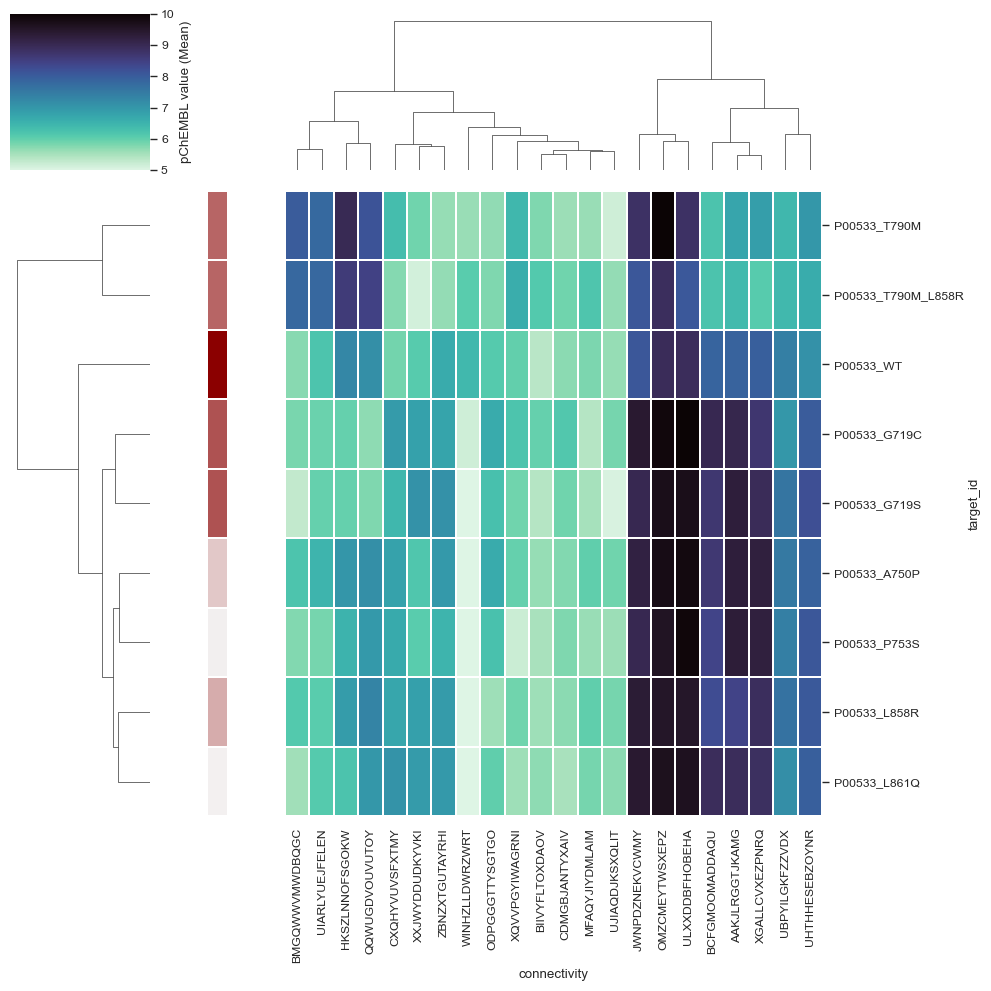

C:\Users\gorostiolam\AppData\Local\Continuum\anaconda3\envs\mutants-in-pcm\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


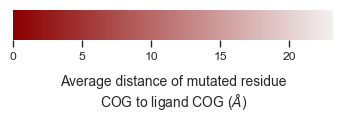

In [68]:
# Plot clustermap with distance to ligand
plot_bioactivity_clustermap(accession, strictly_common_subset_df, None, 'ligand_distance', os.path.join(output_dir,
                                                                                           'clustermaps'),
                            **{'dist_dir':dist_dir})

C:\Users\gorostiolam\Documents\Gorostiola Gonzalez, Marina\PROJECTS\6_Mutants_PCM\PROTOCOLS-SCRIPTS\Python\mutants-in-pcm\src\mutants-in-pcm\mutant_analysis_clustermaps.py:308: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(output_dir, f'clustermap_{accession}_epstein_groups_legend.svg'))


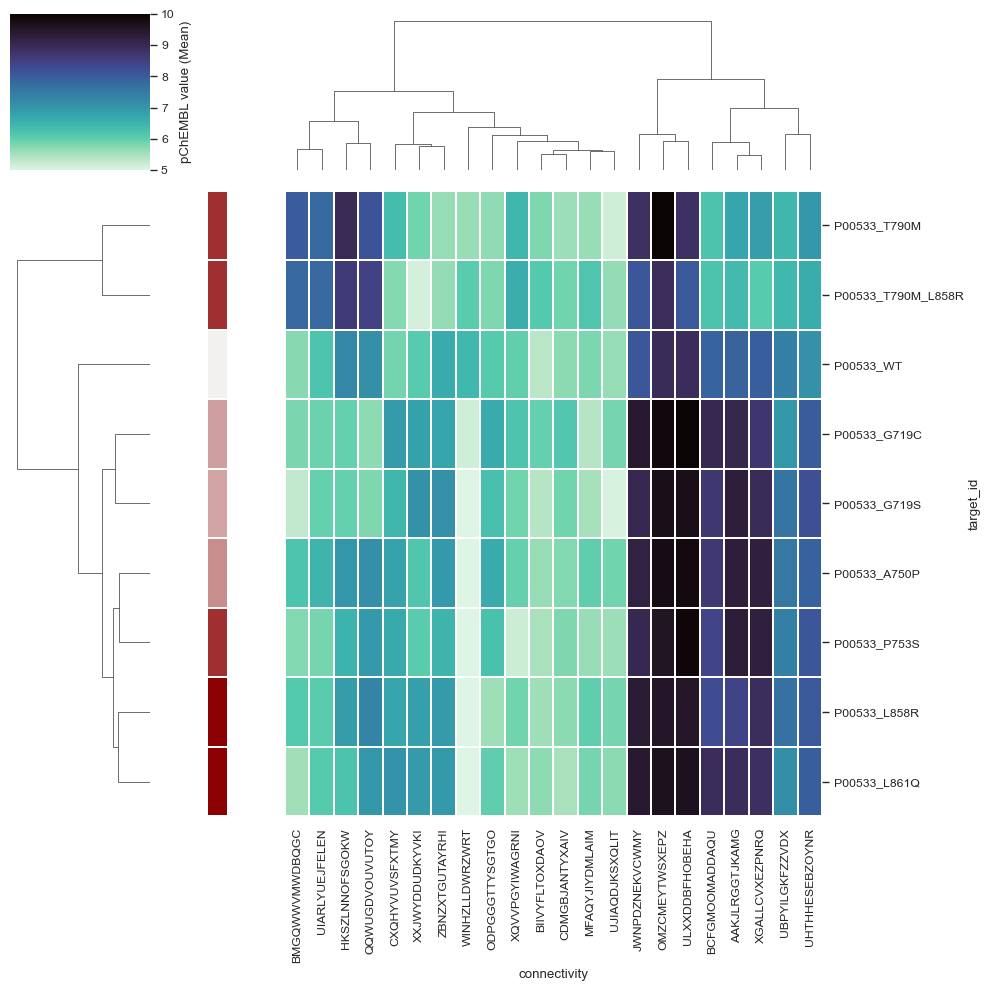

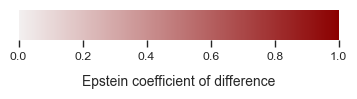

In [69]:
# Plot clustermap with Epstein coefficient of difference
epstein_dict = read_mutation_distance_Epstein()
plot_bioactivity_clustermap(accession, strictly_common_subset_df, None, 'aa_change_epstein', os.path.join(output_dir,
                                                                                           'clustermaps'),
                            **{'epstein_dict':epstein_dict})

##### Bubble plot per clusters

In [70]:
from mutant_analysis_compounds import plot_bioactivity_distribution_cluster_subset,get_clustering_stats
from mutant_analysis_common_subsets import plot_bubble_bioactivity_distribution_stats
output_dir = f'C:\\Users\\gorostiolam\\Documents\\Gorostiola Gonzalez, ' \
             f'Marina\\PROJECTS\\6_Mutants_PCM\\DATA\\2_Analysis\\1_mutant_statistics\\4_compound_clusters\\round_{annotation_round}'

In [71]:
# Plot distributions of bioactivities in most populated Butina clusters for targets with > 90 compounds in common
    # subsets
for accession in ['P00533']:
    plot_bioactivity_distribution_cluster_subset(accession, annotation_round, output_dir)

Loaded 1222 clusters for P00533
P00533 already plotted and statistics analyzed. Skipping...
P00533 already plotted and statistics analyzed. Skipping...
P00533 already plotted and statistics analyzed. Skipping...
P00533 already plotted and statistics analyzed. Skipping...
P00533 already plotted and statistics analyzed. Skipping...
P00533 already plotted and statistics analyzed. Skipping...
P00533 already plotted and statistics analyzed. Skipping...
P00533 already plotted and statistics analyzed. Skipping...
P00533 already plotted and statistics analyzed. Skipping...
P00533 already plotted and statistics analyzed. Skipping...


In [72]:
get_clustering_stats('P00533', os.path.join(output_dir, 'P00533'), 'full_set', '0.5')

Number of clusters: 120
Number of compounds in clusters: 1222
Number of compounds per cluster:
Cluster 1: 253 compounds
Cluster 2: 236 compounds
Cluster 3: 91 compounds
Cluster 4: 78 compounds
Cluster 5: 35 compounds
Cluster 6: 35 compounds
Cluster 7: 30 compounds
Cluster 8: 29 compounds
Cluster 9: 28 compounds
Cluster 10: 26 compounds
Cluster 11: 24 compounds
Cluster 12: 23 compounds
Cluster 13: 20 compounds
Cluster 14: 20 compounds
Cluster 15: 19 compounds
Cluster 16: 19 compounds
Cluster 17: 16 compounds
Cluster 18: 13 compounds
Cluster 19: 12 compounds
Cluster 20: 12 compounds
Cluster 21: 11 compounds
Cluster 22: 10 compounds
Cluster 23: 7 compounds
Cluster 24: 6 compounds
Cluster 25: 6 compounds
Cluster 26: 5 compounds
Cluster 27: 5 compounds
Cluster 28: 5 compounds
Cluster 29: 5 compounds
Cluster 30: 4 compounds
Cluster 31: 4 compounds
Cluster 32: 4 compounds
Cluster 33: 4 compounds
Cluster 34: 4 compounds
Cluster 35: 4 compounds
Cluster 36: 4 compounds
Cluster 37: 4 compounds
Cl

C:\Users\gorostiolam\Documents\Gorostiola Gonzalez, Marina\PROJECTS\6_Mutants_PCM\PROTOCOLS-SCRIPTS\Python\mutants-in-pcm\src\mutants-in-pcm\mutant_analysis_common_subsets.py:932: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([' '.join(label.split('_')[1:]) for label in ls])


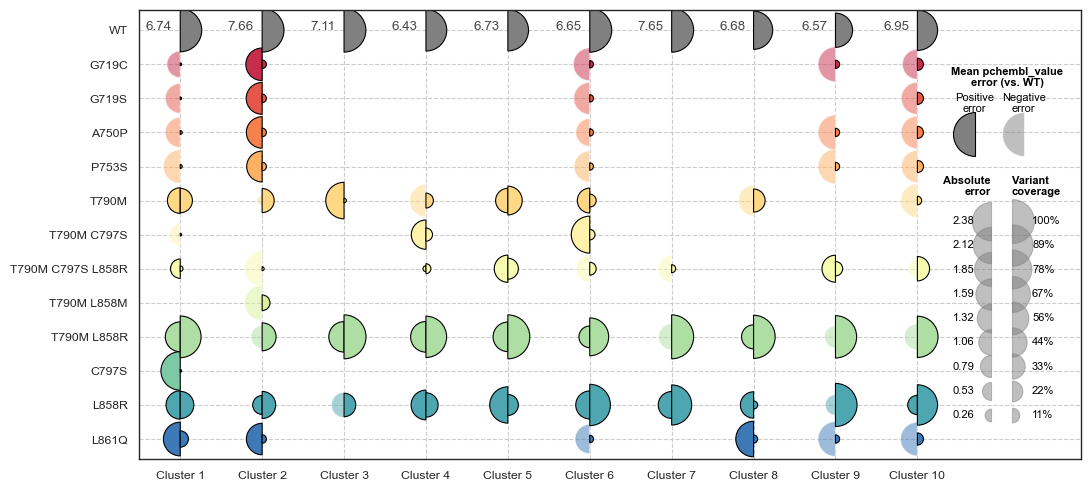

In [73]:
# Plot bubble plot
plot_bubble_bioactivity_distribution_stats(output_dir, 'butina_clusters', 'P00533', 'mean_error', output_dir, True)